# Robot-dance model with optimal vaccination

This notebook includes vaccination in the robot-dance model and find the best strategyy considering some constraints.

In [1]:
import numpy as np
import gekko as gk

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from scipy.integrate import solve_ivp

Matplorlib setting.

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

Consider the problem 

\begin{split}
    \min_{u \in L_1([0,T])} &\sum_{i=1}^K c_v \int_0^T u_i(S_i + E_i + R_i)n_i \, dt + c_h \int_0^T r_h I_i n_i \, dt, \\[0.5px]
    \text{s.a. } &\sum_{j=1}^K V_i(t) n_i \le D(t), \text{ a.e. } t \in [0,T] \\[0.5px] 
    &u_i(t)\cdot (S_i(t) + E_i(t) + R_i(t)) \le D_i, \text{ a.e. } t \in [0,T] \\[0.5px]
    &u_i(t) \ge 0, i = 1,\dots,K, \text{ a.e. } t \in [0,T] \\[0.5px] 
    &\frac{dS_i}{dt} = -\alpha \beta_i S_i I_i - (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - u_i S_i \\
    &\frac{dE_i}{dt} = \alpha \beta_i S_i I_i + (1-\alpha) S_i \sum_{j=1}^K \beta_j p_{ij} I_j^{\mathrm{eff}} - \tau E_i - u_i E_i \\
    &\frac{dI_i}{dt} = \tau E_i - \gamma I_i \\
    &\frac{dR_i}{dt} = \gamma I_i - u_i R_i \\
    &\frac{dV_i}{dt} = u_i \cdot (S_i + E_i + R_i) \\
    &S_i(0) = s_{i0}, E_i(0) = e_{i0}, I_i(0) = i_{i0}, R_i(0) = r_{i0}, V_i(0) = 0.
\end{split}

In [3]:
def model_ode(t, y, u, alpha, beta, tau, gamma, K, p_matrix, population, population_eff):
    """
    Defines a system of ordinary differential equations (ODEs) for a compartmental model in epidemiology.

    Parameters:
    t (float): The current time.
    y (array-like): The current state of the system. Should be a 1D array of length 4*K, 
                    where the first K elements represent the susceptible individuals, 
                    the next K elements represent the exposed individuals, 
                    the next K elements represent the infectious individuals, 
                    and the last K elements represent the recovered individuals.
    u (array-like): The vaccinatio rate for each city.
                    Should be a 1D array of length K.
    alpha (float): Proportion of the night among the 24 hours.
    beta (array-like): The transmission rate for each city. 
                       Should be a 1D array of length K.
    tau (float): The rate at which exposed individuals become infectious (the inverse of the incubation period).
    gamma (float): The recovery rate (the inverse of the infectious period).
    K (int): The number of cities or groups in the population.
    p_matrix (array-like): A matrix that represents the transitions between different cities. 
                           Should be a 2D array of shape (K, K).
    population (array-like): The total population in each city. 
                             Should be a 1D array of length K.
    population_eff (array-like): The effective population during the day.
                                 Should be a 1D array of length K.
                                 P_i^{\mathrm{eff}} = \sum_{j=1}^K p_matrix{ji} population_j
                                 
    Returns:
    array-like: The rates of change of the susceptible, exposed, infectious, and recovered individuals. 
                Returns a 1D array of length 4*K.
    """
    S, E, I, R, _ = y[:K], y[K:2*K], y[2*K:3*K], y[3*K:4*K], y[4*K:]
    I_eff = (I * population) @ p_matrix / population_eff
    S_dot = -alpha * beta * S * I - (1-alpha) * S * (p_matrix @ (beta * I_eff))
    E_dot = -S_dot - (tau + u) * E
    I_dot = tau * E - gamma * I
    R_dot = gamma * I - u*R
    S_dot -= u*S
    H_dot = tau * E
    
    return np.hstack([S_dot, E_dot, I_dot, R_dot, H_dot])

Now the optimal control program.

In [4]:
def optimal_vaccination_strategy(parameters):
    
    # Gekko object
    m = gk.GEKKO()
    
    # Including the time
    T = parameters['T']
    npd = 20
    n_points = npd*T + 1
    m.time = np.linspace(0, T, n_points)

    # Number of cities
    populations = parameters['populations']/parameters['populations'].sum()
    K = len(populations)

    # Parameters
    beta = parameters['beta']
    cv = m.Const(parameters['cv'])
    ch = m.Const(parameters['ch'])
    rh = m.Const(parameters['rh'])
    alpha = m.Const(parameters['alpha'])
    tau = m.Const(parameters['tau'])
    gamma = m.Const(parameters['gamma'])
    p = parameters['p_matrix']
    population_eff = populations @ p_matrix

    # Initial values
    e0 = parameters['e0']
    i0 = parameters['i0']
    r0 = parameters['r0']
    s0 = np.ones(K) - e0 - i0 - r0
    
    # Constraints
    week_max = parameters['week_max']
    rate_max = parameters['rate_max']

    # Including the variables
    s = m.Array(m.Var, K, lb=0.0)
    e = m.Array(m.Var, K, lb=0.0)
    i = m.Array(m.Var, K, lb=0.0)
    r = m.Array(m.Var, K, lb=0.0)
    v = m.Array(m.Var, K, lb=0.0, value=0.0)
    h = m.Array(m.Var, K, lb=0.0, value=0.0)

    u = [m.MV(lb=0.0, value=0.01, name='u{}'.format(city)) for city in range(K)]
    for city in range(K):
        s[city].value = s0[city]
        e[city].value = e0[city]
        i[city].value = i0[city]
        r[city].value = r0[city]
        
        u[city].STATUS = 1
        u[city].DCOST = 0

    # Maximizing 
    obj_points = np.zeros(n_points)
    obj_points[-1] = 1.0
    final = m.Param(value=obj_points)
    m.Obj(cv * m.sum(v*populations) * final + ch * m.sum(h*populations) * final)

    # ODE equations
    i_eff = [m.Intermediate(m.sum(p_matrix[:,city]*populations*i)/population_eff[city]) for city in range(K)]
    for city in range(K):
        new_infections = s[city] * (alpha*beta[city]*i[city] + (1-alpha)*m.sum(beta*p_matrix[city,:]*i_eff))
        m.Equation(s[city].dt() == -new_infections - s[city]*u[city])
        m.Equation(e[city].dt() == new_infections - (tau+u[city])*e[city])
        m.Equation(i[city].dt() == tau*e[city] - gamma*i[city])
        m.Equation(r[city].dt() == gamma*i[city] - u[city]*r[city])
        m.Equation(v[city].dt() == u[city]*(s[city] + e[city] + r[city]))
        m.Equation(h[city].dt() == rh*i[city])
        
        # The vaccination rate is limited
        m.Equation(u[city]*(s[city] + e[city] + r[city]) <= rate_max[city])
        
        
    weekly_constraint = []
    weekly_mark = []
    for week in range(T//7):
        weekly_mark.append(np.zeros(n_points))
        weekly_mark[-1][npd*7*(week+1)] = 1.0
        weekly_constraint.append(m.Param(value=weekly_mark[-1]))
        m.Equation( m.sum(v * populations) * weekly_constraint[-1] <= week_max[week])

    # Solving
    m.options.IMODE = 6
    m.options.NODES = 6
    m.options.MV_TYPE = 1
    m.options.SOLVER = 3  # Using IPOPT solver
    m.options.MAX_ITER = 500
    
    m.options.RTOL=parameters['RTOL']
    m.options.OTOL=parameters['OTOL']

    m.solve(disp=True)
    
    return m, s, e, i, r, v, h, u

## Two cities

In [5]:
# Setting the parameters
K = 2

populations = np.array([1e6, 1e5])
p_matrix = np.array([[1,0],[0.2, 0.8]])
population_eff = populations @ p_matrix

beta = np.array([0.4, 0.2])
alpha = 0.64
tau = 1/3
gamma = 1/7

T = 56

rate_max = np.array([0.9, 0.8])/T
week_max = np.array([1, 2, 3, 4, 5, 6, 7, 8])/13

Running up to some day.

In [6]:
# Initial condition
y0 = np.zeros(5*K)
y0[K] = 1/populations[0]
y0[0:K] = 1-y0[K:2*K]

n_days = 180
t_eval = np.linspace(0, n_days, 100 * n_days)

args = (np.zeros(2), alpha, beta, tau, gamma, K, p_matrix, populations, population_eff)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
                max_step=1e-2
               )

In [7]:
%%time
parameters = {'T': T, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': sol.y[2:4,75*100], 
              'i0': sol.y[4:6,75*100], 
              'r0': sol.y[6:8,75*100],
              'cv': 0.01, 'ch': 1000, 'rh': 0.1,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-7, 'OTOL': 1e-7}

m, susceptible, exposed, infected, recovered, vaccinated, hospitalized, u = optimal_vaccination_strategy(parameters)

apm 46.193.0.20_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           33
   Intermediates:            2
   Connections  :            0
   Equations    :           25
   Residuals    :           23
 
 Number of state variables:         210560
 Number of total equations: -       208320
 Number of slack variables: -        56000
 ---------------------------------------
 Degrees of freedom       :         -53760
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This pr

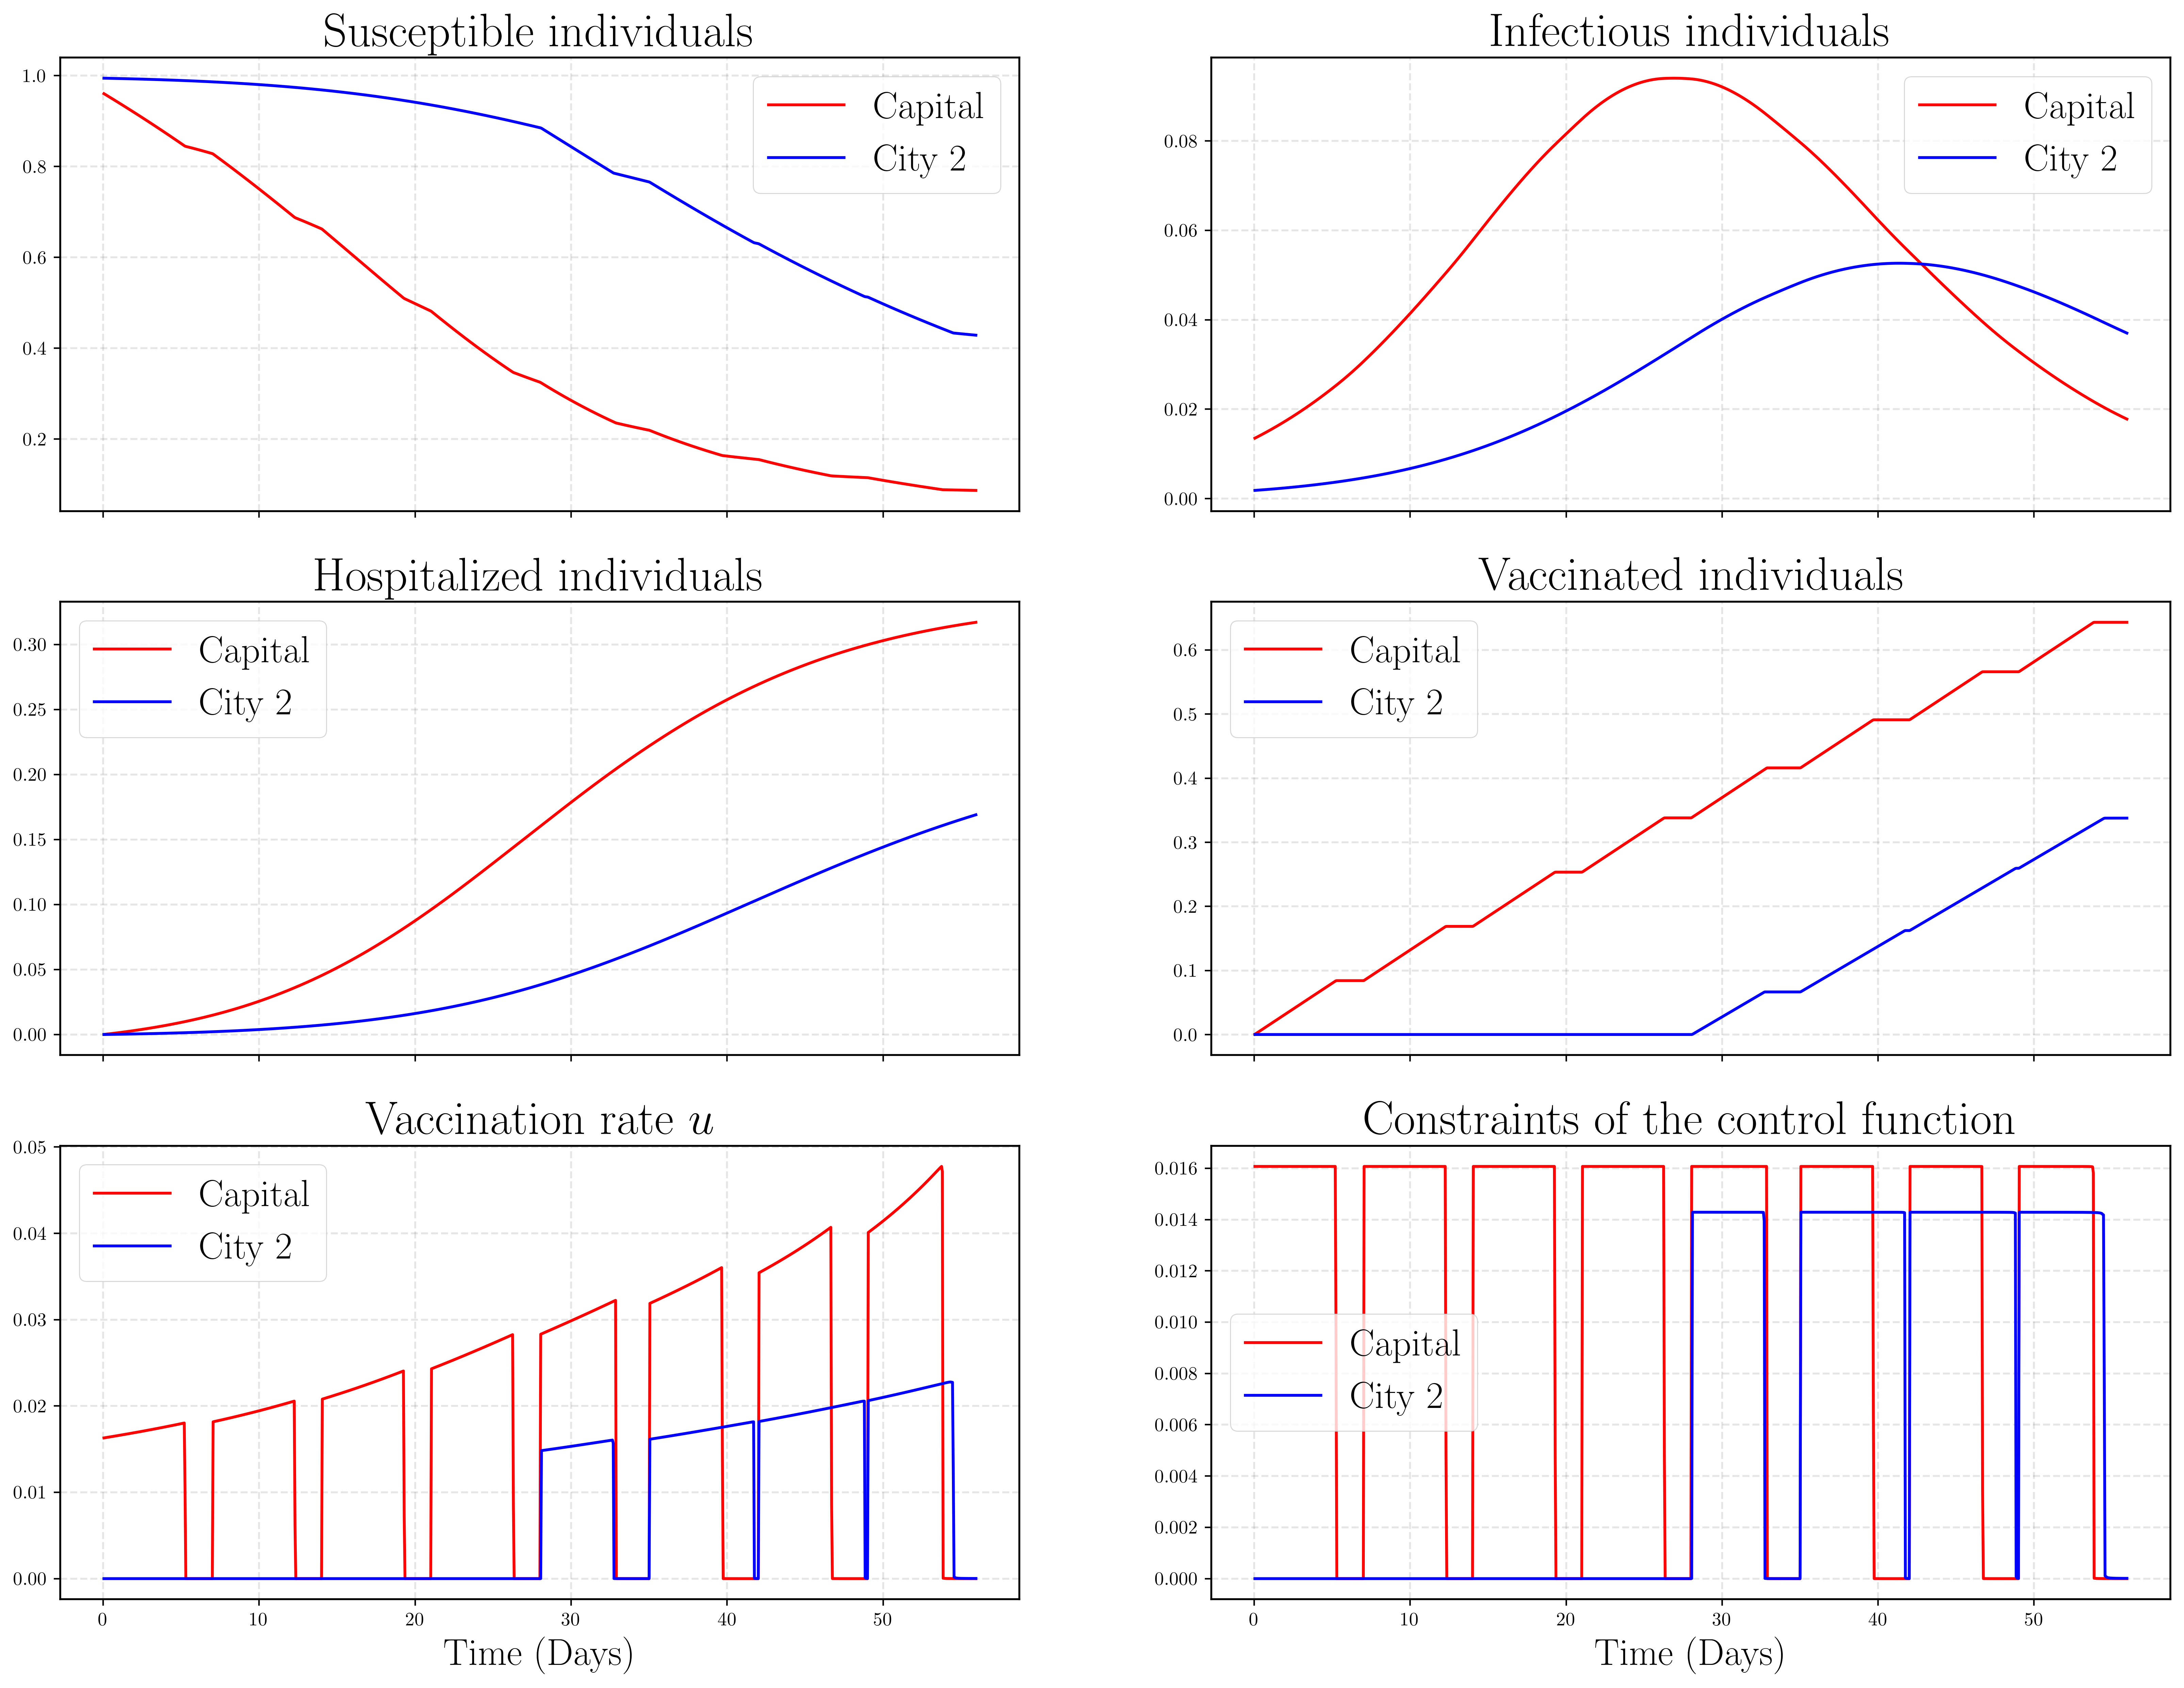

In [39]:
fig, ax = plt.subplots(3,2, figsize=(20,15), sharex=True)

colors = ['red', 'blue']
labels = ['Capital', 'City 2']

for city in range(len(populations)):
    
    ax[0,0].plot(m.time[1:-1], susceptible[city][1:-1], label=labels[city], c=colors[city])
    ax[0,1].plot(m.time[1:-1], infected[city][1:-1], label=labels[city], c=colors[city])
    
    ax[1,0].plot(m.time[1:-1], hospitalized[city][1:-1], label=labels[city], c=colors[city])
    ax[1,1].plot(m.time[1:-1], vaccinated[city][1:-1], label=labels[city], c=colors[city])
    
    ax[2,0].plot(m.time[1:-1], u[city][1:-1], label=labels[city], c=colors[city])
    
    constraint = np.array(u[city])*(np.array(susceptible[city])+np.array(exposed[city])+np.array(recovered[city]))
    
    ax[2,1].plot(m.time[1:-1], constraint[1:-1], 
                 label=labels[city], color=colors[city])
    
for i in range(3):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
ax[0,0].set_title('Susceptible individuals', fontsize=25)
ax[0,1].set_title('Infectious individuals', fontsize=25)
ax[1,0].set_title('Hospitalized individuals', fontsize=25)
ax[1,1].set_title('Vaccinated individuals', fontsize=25)
ax[2,0].set_title(r'Vaccination rate $u$', fontsize=25)
ax[2,1].set_title('Constraints of the control function', fontsize=25)

ax[2,0].set_xlabel('Time (Days)', fontsize=20)
ax[2,1].set_xlabel('Time (Days)', fontsize=20)

ax[0,0].legend(fontsize=20)
ax[0,1].legend(fontsize=20)
ax[1,0].legend(fontsize=20)
ax[1,1].legend(fontsize=20)
ax[2,0].legend(fontsize=20)
ax[2,1].legend(fontsize=20)

plt.savefig('../images/numerical_simulations_control.pdf', bbox_inches='tight')

plt.show()

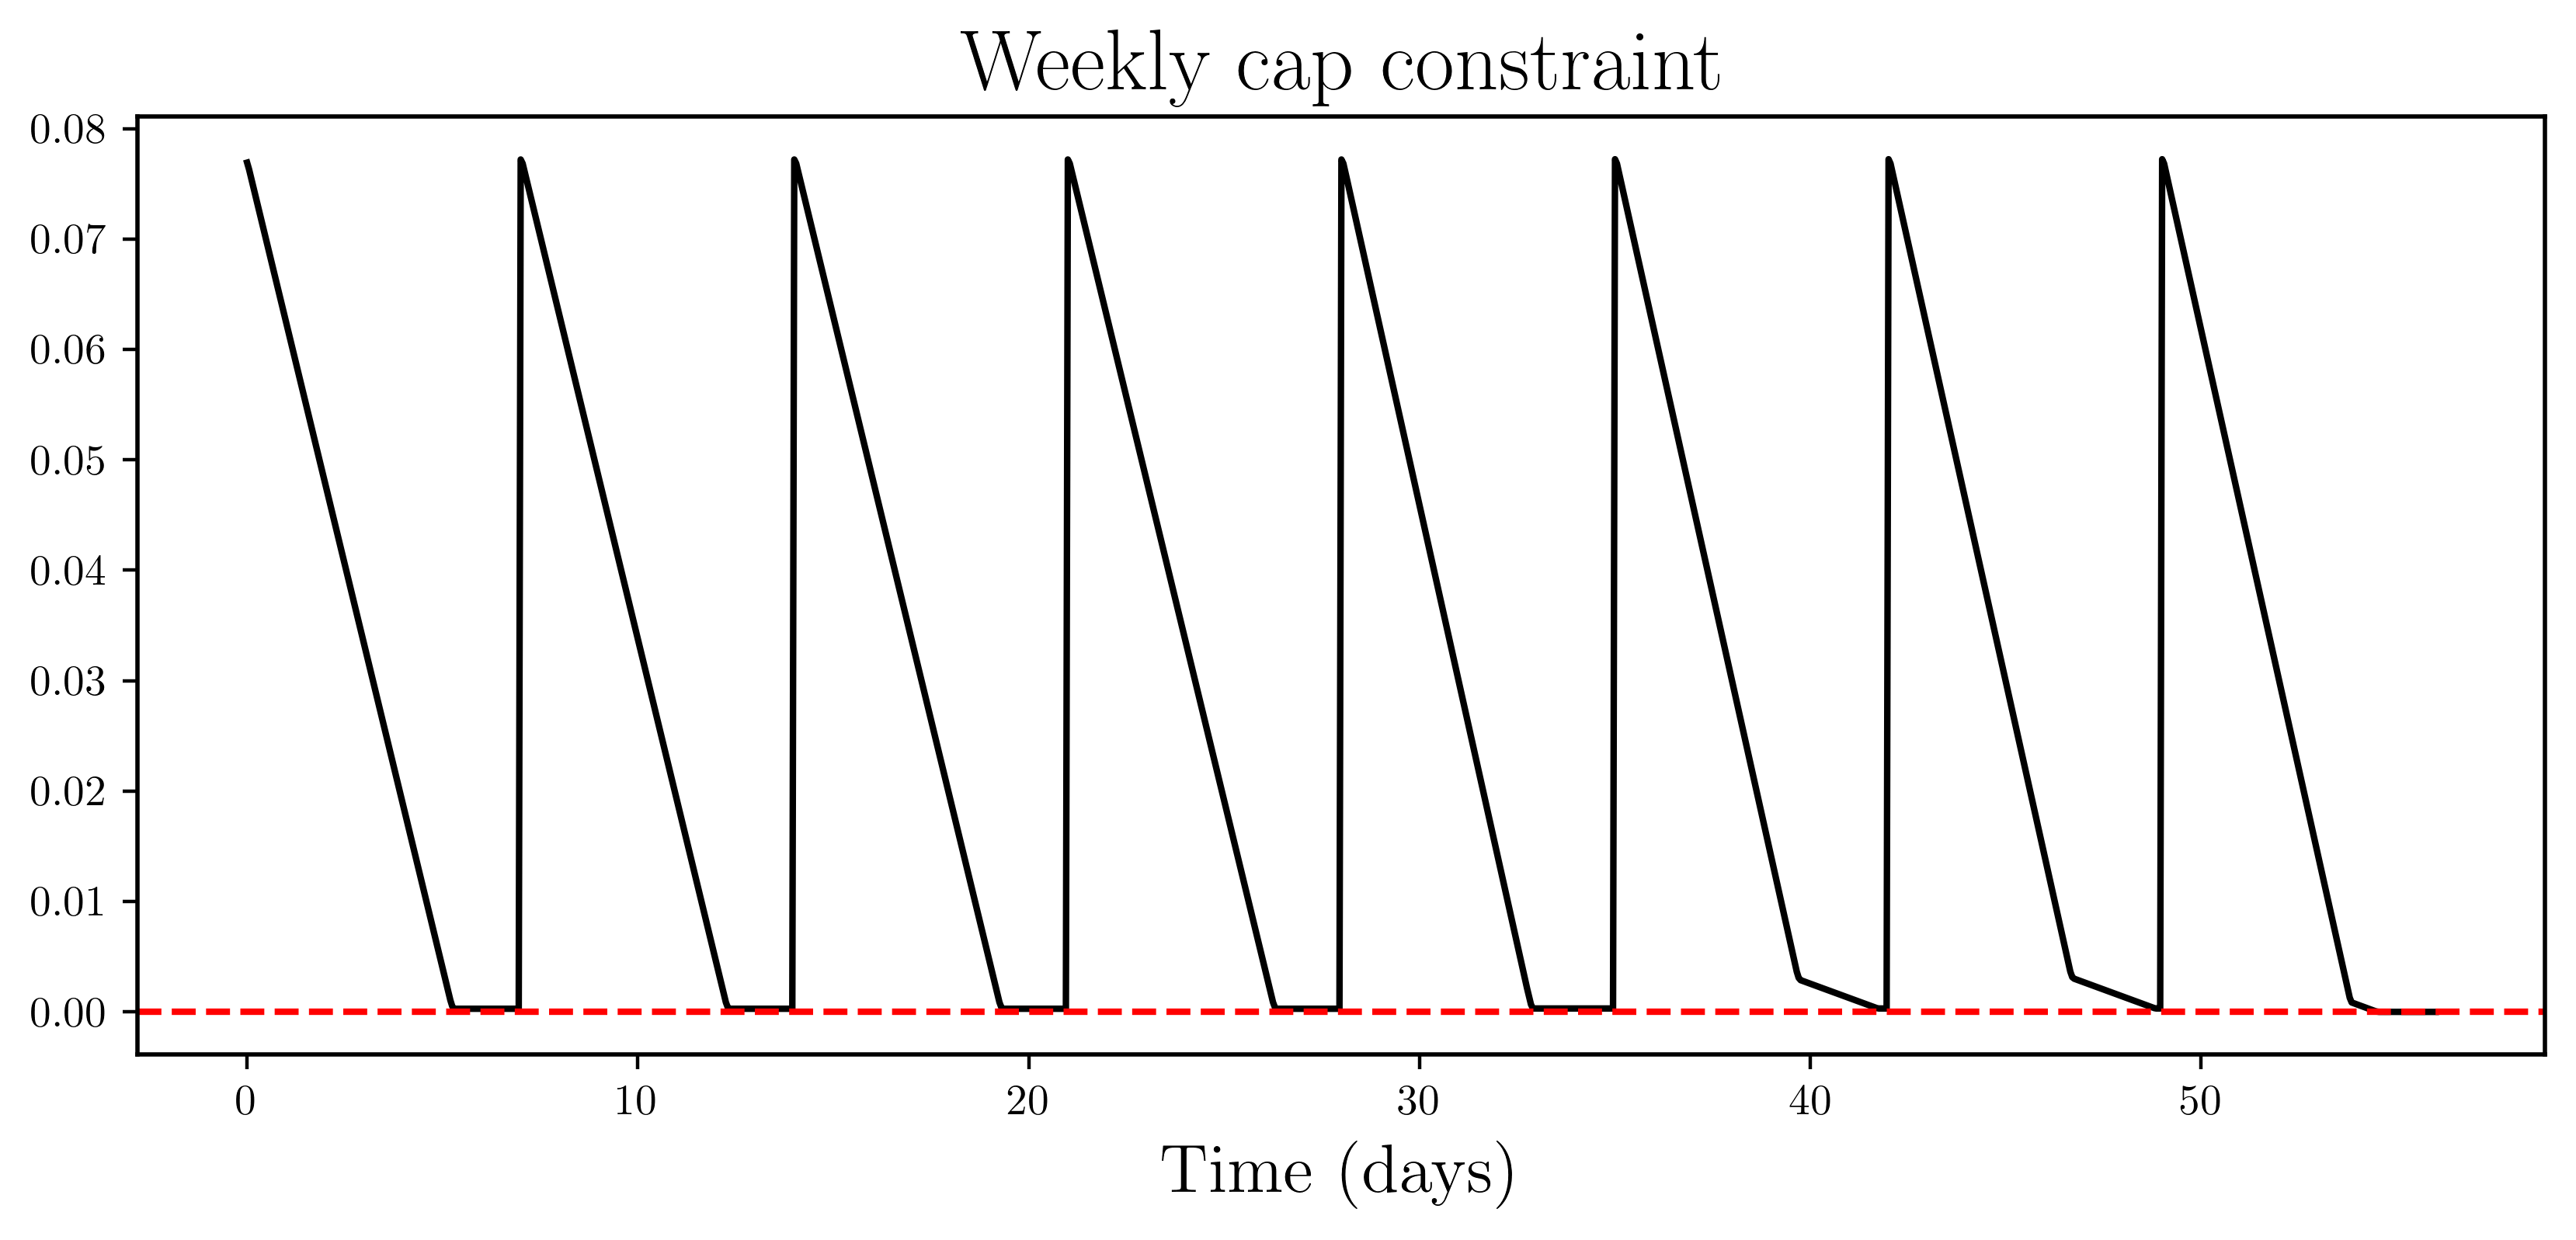

In [38]:
D_t = 0
for i in range(8):
    D_t += week_max[i] * ((m.time >= 7*i) * (m.time < 7*(i+1)))
D_t += week_max[7] * (m.time == 56)

plt.figure(figsize=(10,4))
plt.plot(m.time, D_t - (np.array(vaccinated[0])*populations[0] + np.array(vaccinated[1])*populations[1])/populations.sum(), 
         c='black')
plt.axhline(0, ls='--', color='red')
plt.title('Weekly cap constraint', fontsize=20)
plt.xlabel('Time (days)', fontsize=16)

plt.savefig('../images/weekly_cap_two_cities.pdf', bbox_inches='tight')

plt.show()

Starting with the same proportion of susceptible and infected people in each city

In [19]:
# Initial condition
y0 = np.zeros(5*K)
y0[0:2] = 0.9
y0[2:4] = 0.03
y0[4:6] = 0.04
y0[6:8] = 0.03

In [20]:
%%time
parameters = {'T': T, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': y0[2:4], 
              'i0': y0[4:6], 
              'r0': y0[6:8],
              'cv': 0.01, 'ch': 1000, 'rh': 0.1,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-7, 'OTOL': 1e-7}

m, susceptible, exposed, infected, recovered, vaccinated, hospitalized, u = optimal_vaccination_strategy(parameters)

apm 46.193.0.20_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           33
   Intermediates:            2
   Connections  :            0
   Equations    :           25
   Residuals    :           23
 
 Number of state variables:         210560
 Number of total equations: -       208320
 Number of slack variables: -        56000
 ---------------------------------------
 Degrees of freedom       :         -53760
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This pr

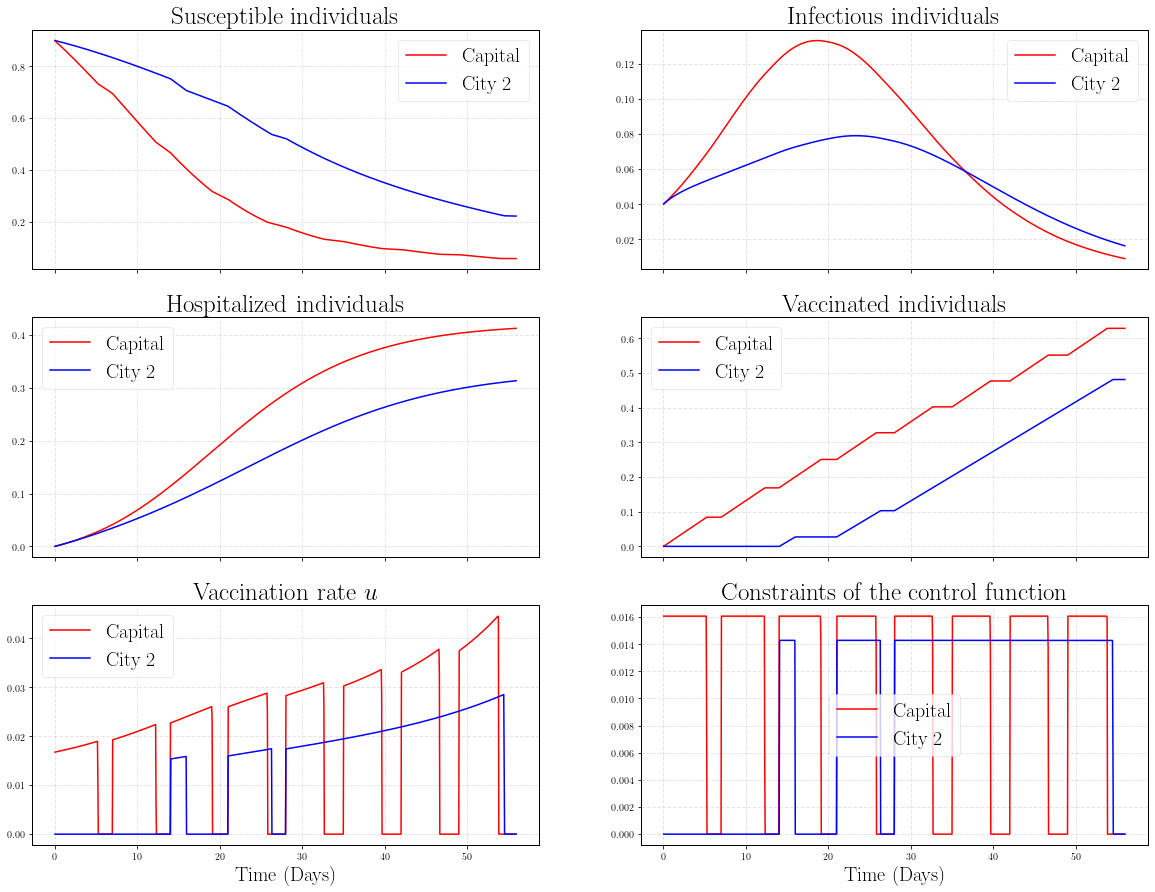

In [21]:
fig, ax = plt.subplots(3,2, figsize=(20,15), sharex=True)

colors = ['red', 'blue']
labels = ['Capital', 'City 2']

for city in range(len(populations)):
    
    ax[0,0].plot(m.time[1:-1], susceptible[city][1:-1], label=labels[city], c=colors[city])
    ax[0,1].plot(m.time[1:-1], infected[city][1:-1], label=labels[city], c=colors[city])
    
    ax[1,0].plot(m.time[1:-1], hospitalized[city][1:-1], label=labels[city], c=colors[city])
    ax[1,1].plot(m.time[1:-1], vaccinated[city][1:-1], label=labels[city], c=colors[city])
    
    ax[2,0].plot(m.time[1:-1], u[city][1:-1], label=labels[city], c=colors[city])
    
    constraint = np.array(u[city])*(np.array(susceptible[city])+np.array(exposed[city])+np.array(recovered[city]))
    
    ax[2,1].plot(m.time[1:-1], constraint[1:-1], 
                 label=labels[city], color=colors[city])
    
for i in range(3):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
ax[0,0].set_title('Susceptible individuals', fontsize=25)
ax[0,1].set_title('Infectious individuals', fontsize=25)
ax[1,0].set_title('Hospitalized individuals', fontsize=25)
ax[1,1].set_title('Vaccinated individuals', fontsize=25)
ax[2,0].set_title(r'Vaccination rate $u$', fontsize=25)
ax[2,1].set_title('Constraints of the control function', fontsize=25)

ax[2,0].set_xlabel('Time (Days)', fontsize=20)
ax[2,1].set_xlabel('Time (Days)', fontsize=20)

ax[0,0].legend(fontsize=20)
ax[0,1].legend(fontsize=20)
ax[1,0].legend(fontsize=20)
ax[1,1].legend(fontsize=20)
ax[2,0].legend(fontsize=20)
ax[2,1].legend(fontsize=20)

plt.savefig('../images/new_numerical_simulations_control_001.pdf', bbox_inches='tight')

plt.show()

In [8]:
parameters = {'T': 28, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': sol.y[2:4,75*100], 
              'i0': sol.y[4:6,75*100], 
              'r0': sol.y[6:8,75*100],
              'cv': 1, 'ch': 100, 'rh': 0.1,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-6, 'OTOL': 1e-6}

m, susceptible, exposed, infected, recovered, vaccinated, hospitalized, u = optimal_vaccination_strategy(parameters)

apm 201.39.147.24_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           25
   Intermediates:            2
   Connections  :            0
   Equations    :           21
   Residuals    :           19
 
 Number of state variables:          94080
 Number of total equations: -        92960
 Number of slack variables: -        16800
 ---------------------------------------
 Degrees of freedom       :         -15680
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

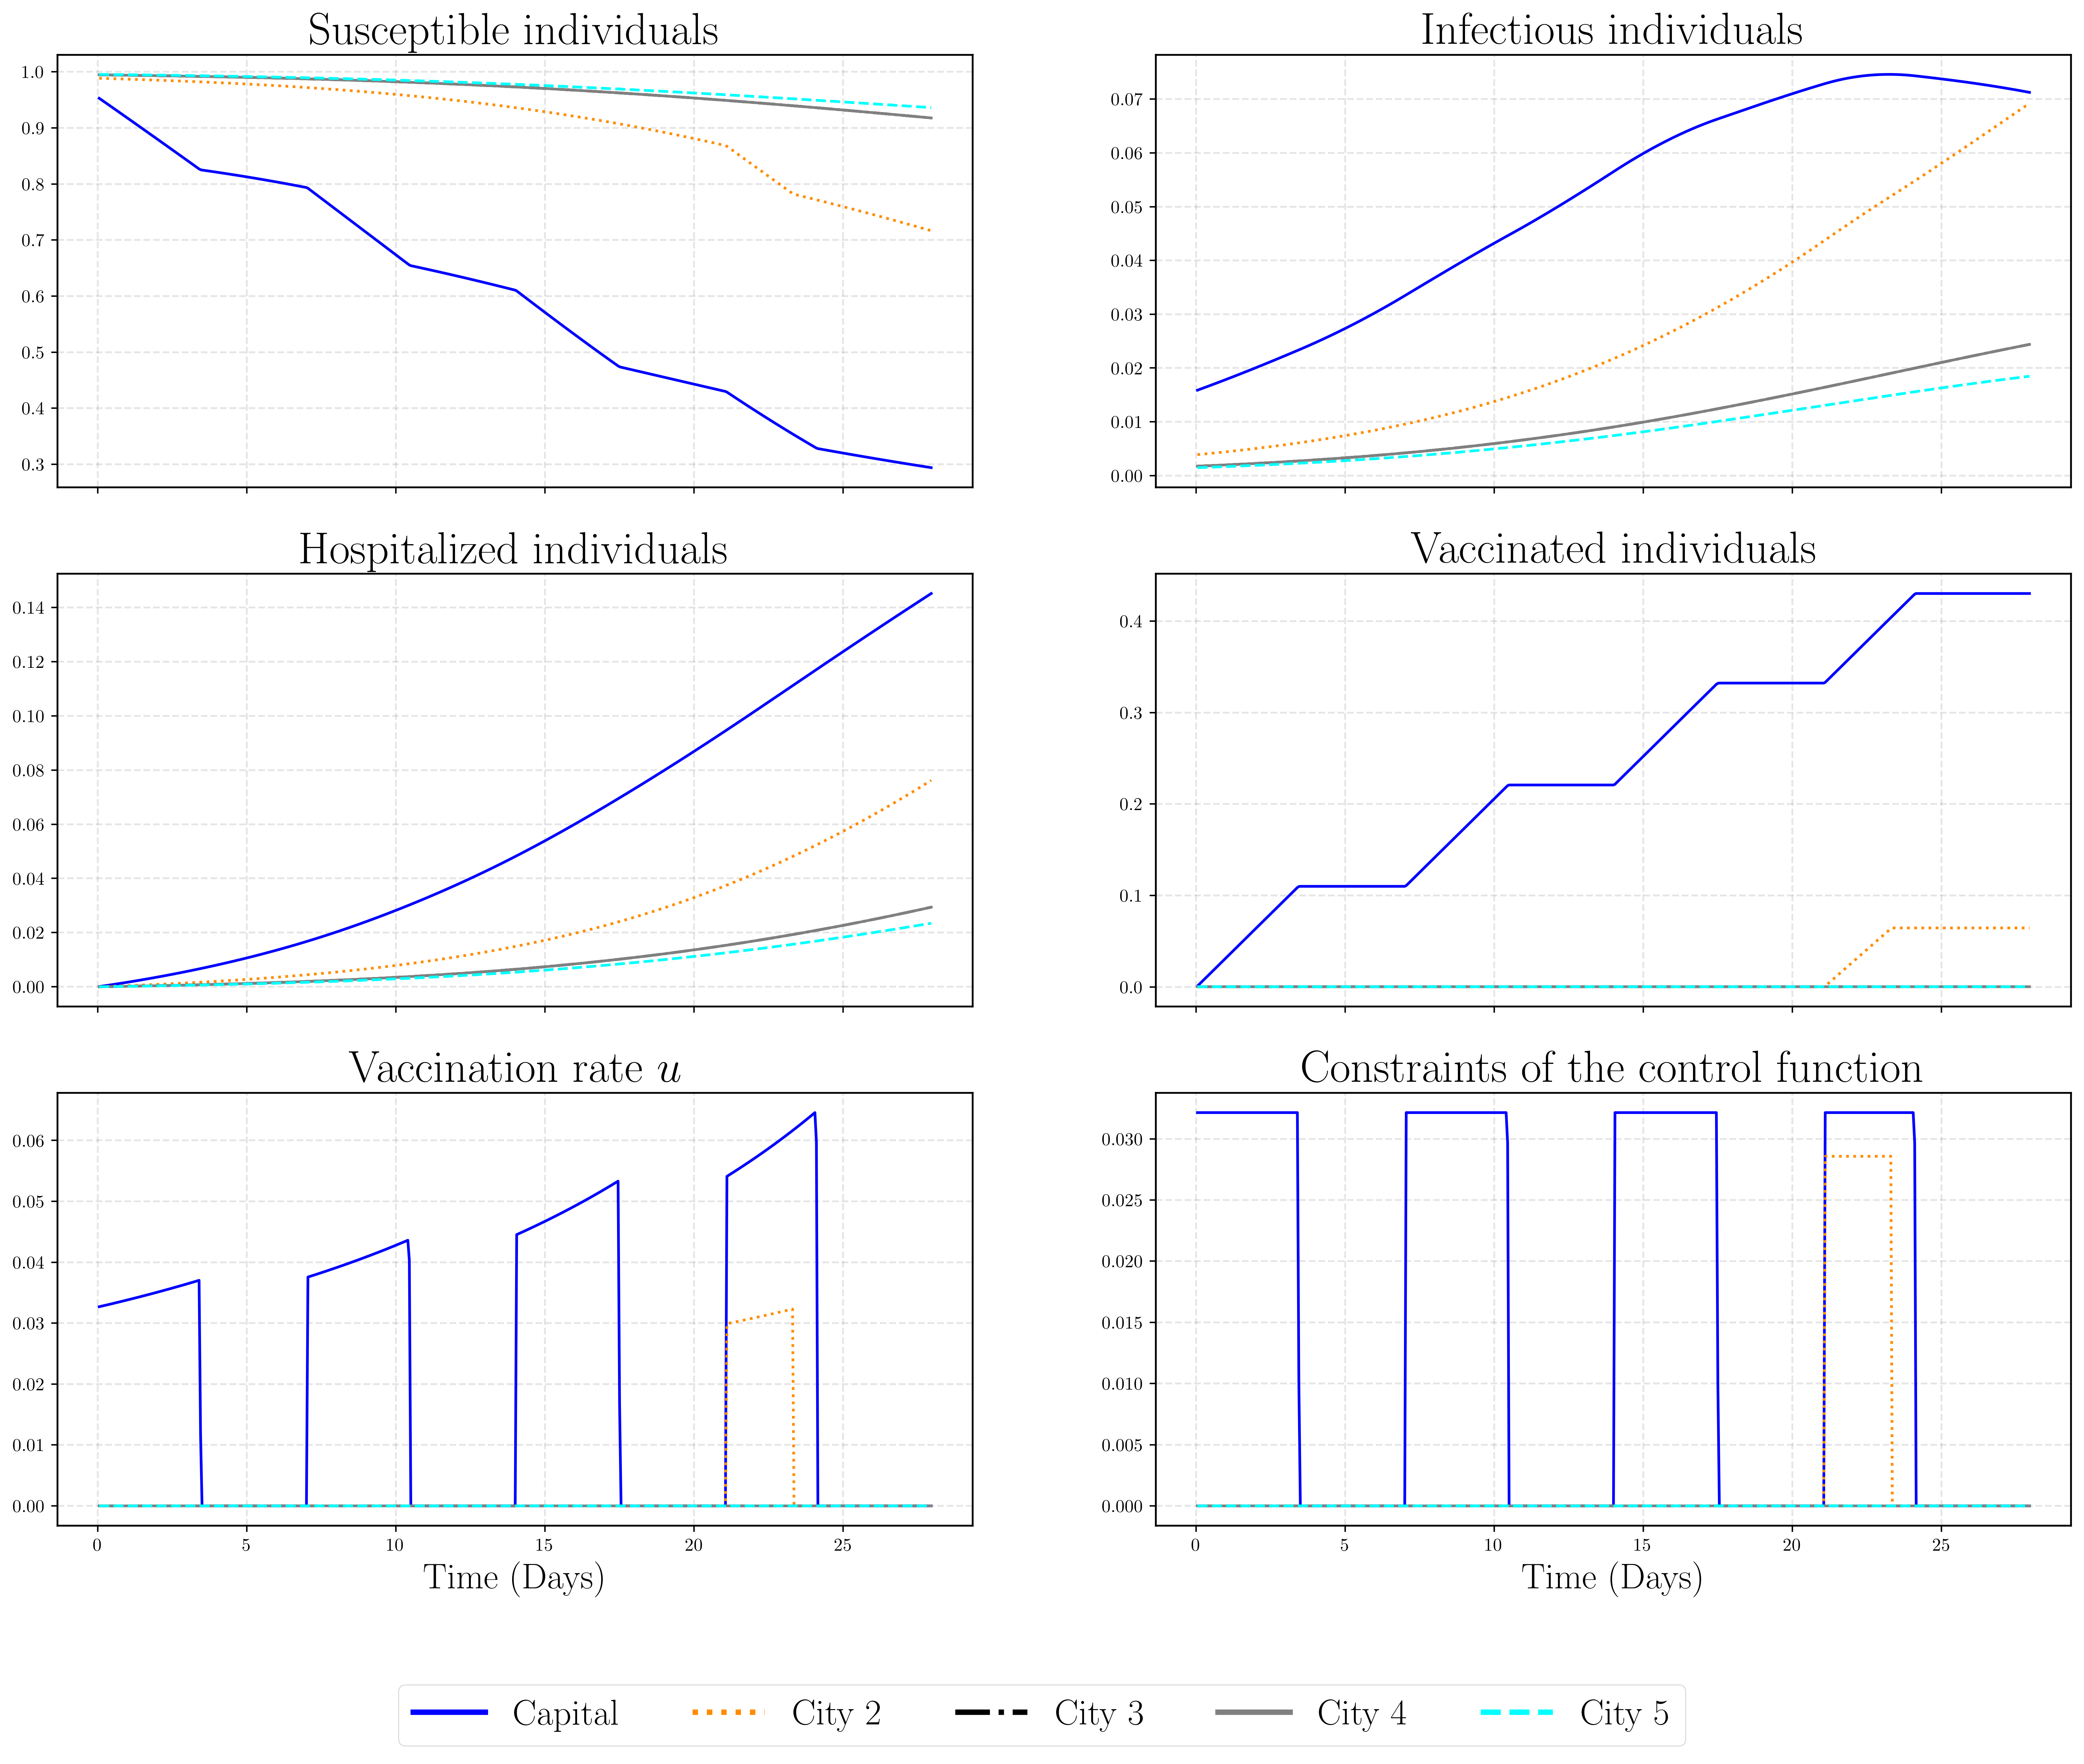

In [23]:
fig, ax = plt.subplots(3,2, figsize=(20,15), sharex=True)

colors = ['red', 'blue']
labels = ['Capital', 'City 2']

for city in range(len(populations)):
    
    ax[0,0].plot(m.time[1:-1], susceptible[city][1:-1], label=labels[city], c=colors[city])
    ax[0,1].plot(m.time[1:-1], infected[city][1:-1], label=labels[city], c=colors[city])
    
    ax[1,0].plot(m.time[1:-1], hospitalized[city][1:-1], label=labels[city], c=colors[city])
    ax[1,1].plot(m.time[1:-1], vaccinated[city][1:-1], label=labels[city], c=colors[city])
    
    ax[2,0].plot(m.time[1:-1], u[city][1:-1], label=labels[city], c=colors[city])
    
    constraint = np.array(u[city])*(np.array(susceptible[city])+np.array(exposed[city])+np.array(recovered[city]))
    
    ax[2,1].plot(m.time[1:-1], constraint[1:-1], 
                 label=labels[city], color=colors[city])
    
for i in range(3):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
ax[0,0].set_title('Susceptible individuals', fontsize=25)
ax[0,1].set_title('Infectious individuals', fontsize=25)
ax[1,0].set_title('Hospitalized individuals', fontsize=25)
ax[1,1].set_title('Vaccinated individuals', fontsize=25)
ax[2,0].set_title(r'Vaccination rate $u$', fontsize=25)
ax[2,1].set_title('Constraints of the control function', fontsize=25)

ax[2,0].set_xlabel('Time (Days)', fontsize=20)
ax[2,1].set_xlabel('Time (Days)', fontsize=20)

ax[0,0].legend(fontsize=20)
ax[0,1].legend(fontsize=20)
ax[1,0].legend(fontsize=20)
ax[1,1].legend(fontsize=20)
ax[2,0].legend(fontsize=20)
ax[2,1].legend(fontsize=20)

#plt.savefig('../images/weekly_cap_two_cities_fig2.pdf', bbox_inches='tight')

plt.show()

In [36]:
beta = np.array([0.3, 0.3])

args = (np.zeros(2), alpha, beta, tau, gamma, K, p_matrix, populations, population_eff)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
                max_step=1e-2
               )

parameters = {'T': 28, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': sol.y[2:4,125*100], 
              'i0': sol.y[4:6,125*100], 
              'r0': sol.y[6:8,125*100],
              'cv': 0.01, 'ch': 1000, 'rh': 0.1,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-6, 'OTOL': 1e-6}

In [37]:
m, susceptible, exposed, infected, recovered, vaccinated, hospitalized, u = optimal_vaccination_strategy(parameters)

apm 201.39.147.24_gk_model2 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           25
   Intermediates:            2
   Connections  :            0
   Equations    :           21
   Residuals    :           19
 
 Number of state variables:          94080
 Number of total equations: -        92960
 Number of slack variables: -        16800
 ---------------------------------------
 Degrees of freedom       :         -15680
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

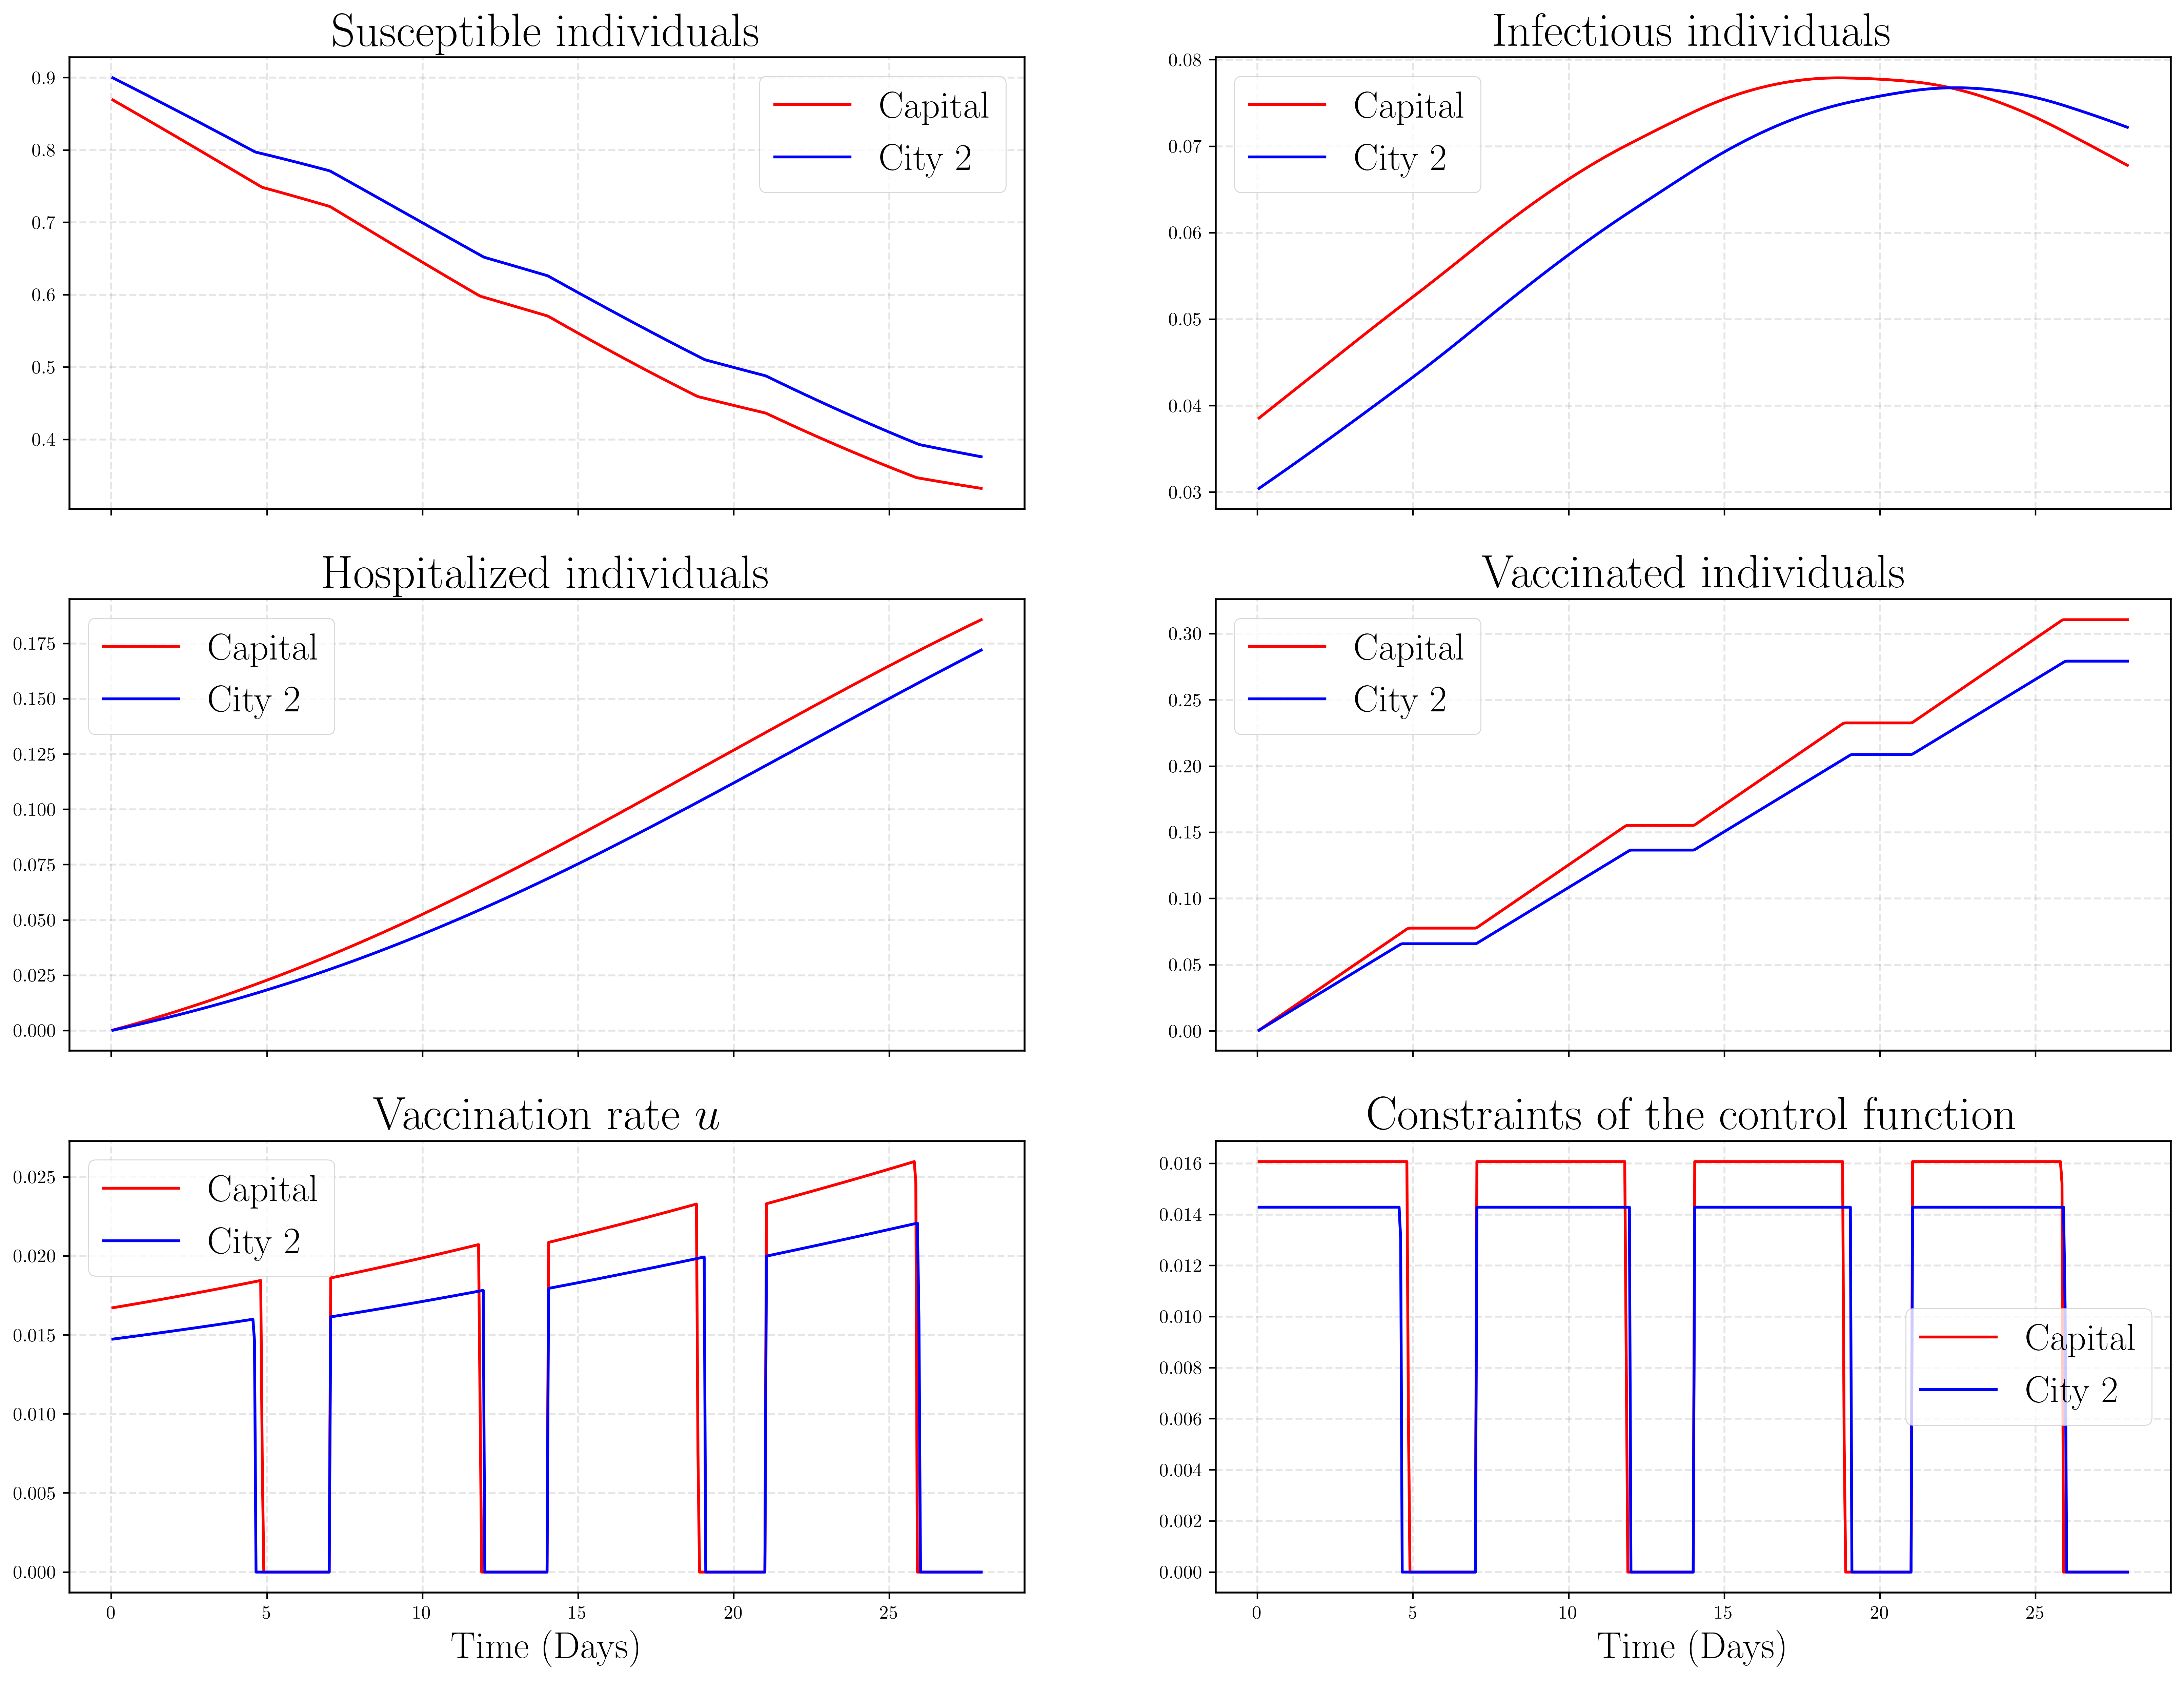

In [41]:
fig, ax = plt.subplots(3,2, figsize=(20,15), sharex=True)

colors = ['red', 'blue']
labels = ['Capital', 'City 2']

for city in range(len(populations)):
    
    ax[0,0].plot(m.time[1:-1], susceptible[city][1:-1], label=labels[city], c=colors[city])
    ax[0,1].plot(m.time[1:-1], infected[city][1:-1], label=labels[city], c=colors[city])
    
    ax[1,0].plot(m.time[1:-1], hospitalized[city][1:-1], label=labels[city], c=colors[city])
    ax[1,1].plot(m.time[1:-1], vaccinated[city][1:-1], label=labels[city], c=colors[city])
    
    ax[2,0].plot(m.time[1:-1], u[city][1:-1], label=labels[city], c=colors[city])
    
    constraint = np.array(u[city])*(np.array(susceptible[city])+np.array(exposed[city])+np.array(recovered[city]))
    
    ax[2,1].plot(m.time[1:-1], constraint[1:-1], 
                 label=labels[city], color=colors[city])
    
for i in range(3):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
ax[0,0].set_title('Susceptible individuals', fontsize=25)
ax[0,1].set_title('Infectious individuals', fontsize=25)
ax[1,0].set_title('Hospitalized individuals', fontsize=25)
ax[1,1].set_title('Vaccinated individuals', fontsize=25)
ax[2,0].set_title(r'Vaccination rate $u$', fontsize=25)
ax[2,1].set_title('Constraints of the control function', fontsize=25)

ax[2,0].set_xlabel('Time (Days)', fontsize=20)
ax[2,1].set_xlabel('Time (Days)', fontsize=20)

ax[0,0].legend(fontsize=20)
ax[0,1].legend(fontsize=20)
ax[1,0].legend(fontsize=20)
ax[1,1].legend(fontsize=20)
ax[2,0].legend(fontsize=20)
ax[2,1].legend(fontsize=20)

plt.savefig('../images/numerical_simulations_control_fig3.pdf', bbox_inches='tight')

plt.show()

## Multi-city interaction

In [5]:
# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
beta = np.array([0.4, 0.3, 0.15, 0.15, 0.1])
alpha = 0.64

# Population settings
x1 = 0.2
populations = 1e5*np.array([50, 10, 10, 1, 1])
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = populations @ p_matrix

# Initial condition
y0 = np.zeros(5*K)
y0[K] = 1/populations[0]
y0[0:K] = 1-y0[K:2*K]

T = 28

rate_max = np.array([0.9, 0.8, 0.8, 0.8, 0.8])/T
week_max = np.array([1, 2, 3, 4, 5, 6, 7, 8])/13

args = (np.zeros(5), alpha, beta, tau, gamma, K, p_matrix, populations, population_eff)

n_days = 180
t_eval = np.linspace(0, n_days, 100 * n_days)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
                max_step=1e-2
               )

In [6]:
%%time
parameters = {'T': T, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': sol.y[K:2*K,90*100], 
              'i0': sol.y[2*K:3*K,90*100], 
              'r0': sol.y[3*K:4*K,90*100],
              'cv': 0.01, 'ch': 1000, 'rh': 0.1,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-6, 'OTOaL': 1e-6}

m, susceptible, exposed, infected, recovered, vaccinated, hospitalized, u = optimal_vaccination_strategy(parameters)

apm 189.125.124.24_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           49
   Intermediates:            5
   Connections  :            0
   Equations    :           45
   Residuals    :           40
 
 Number of state variables:         218400
 Number of total equations: -       215600
 Number of slack variables: -        25200
 ---------------------------------------
 Degrees of freedom       :         -22400
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This

CPU times: total: 109 ms
Wall time: 1h 35min 2s


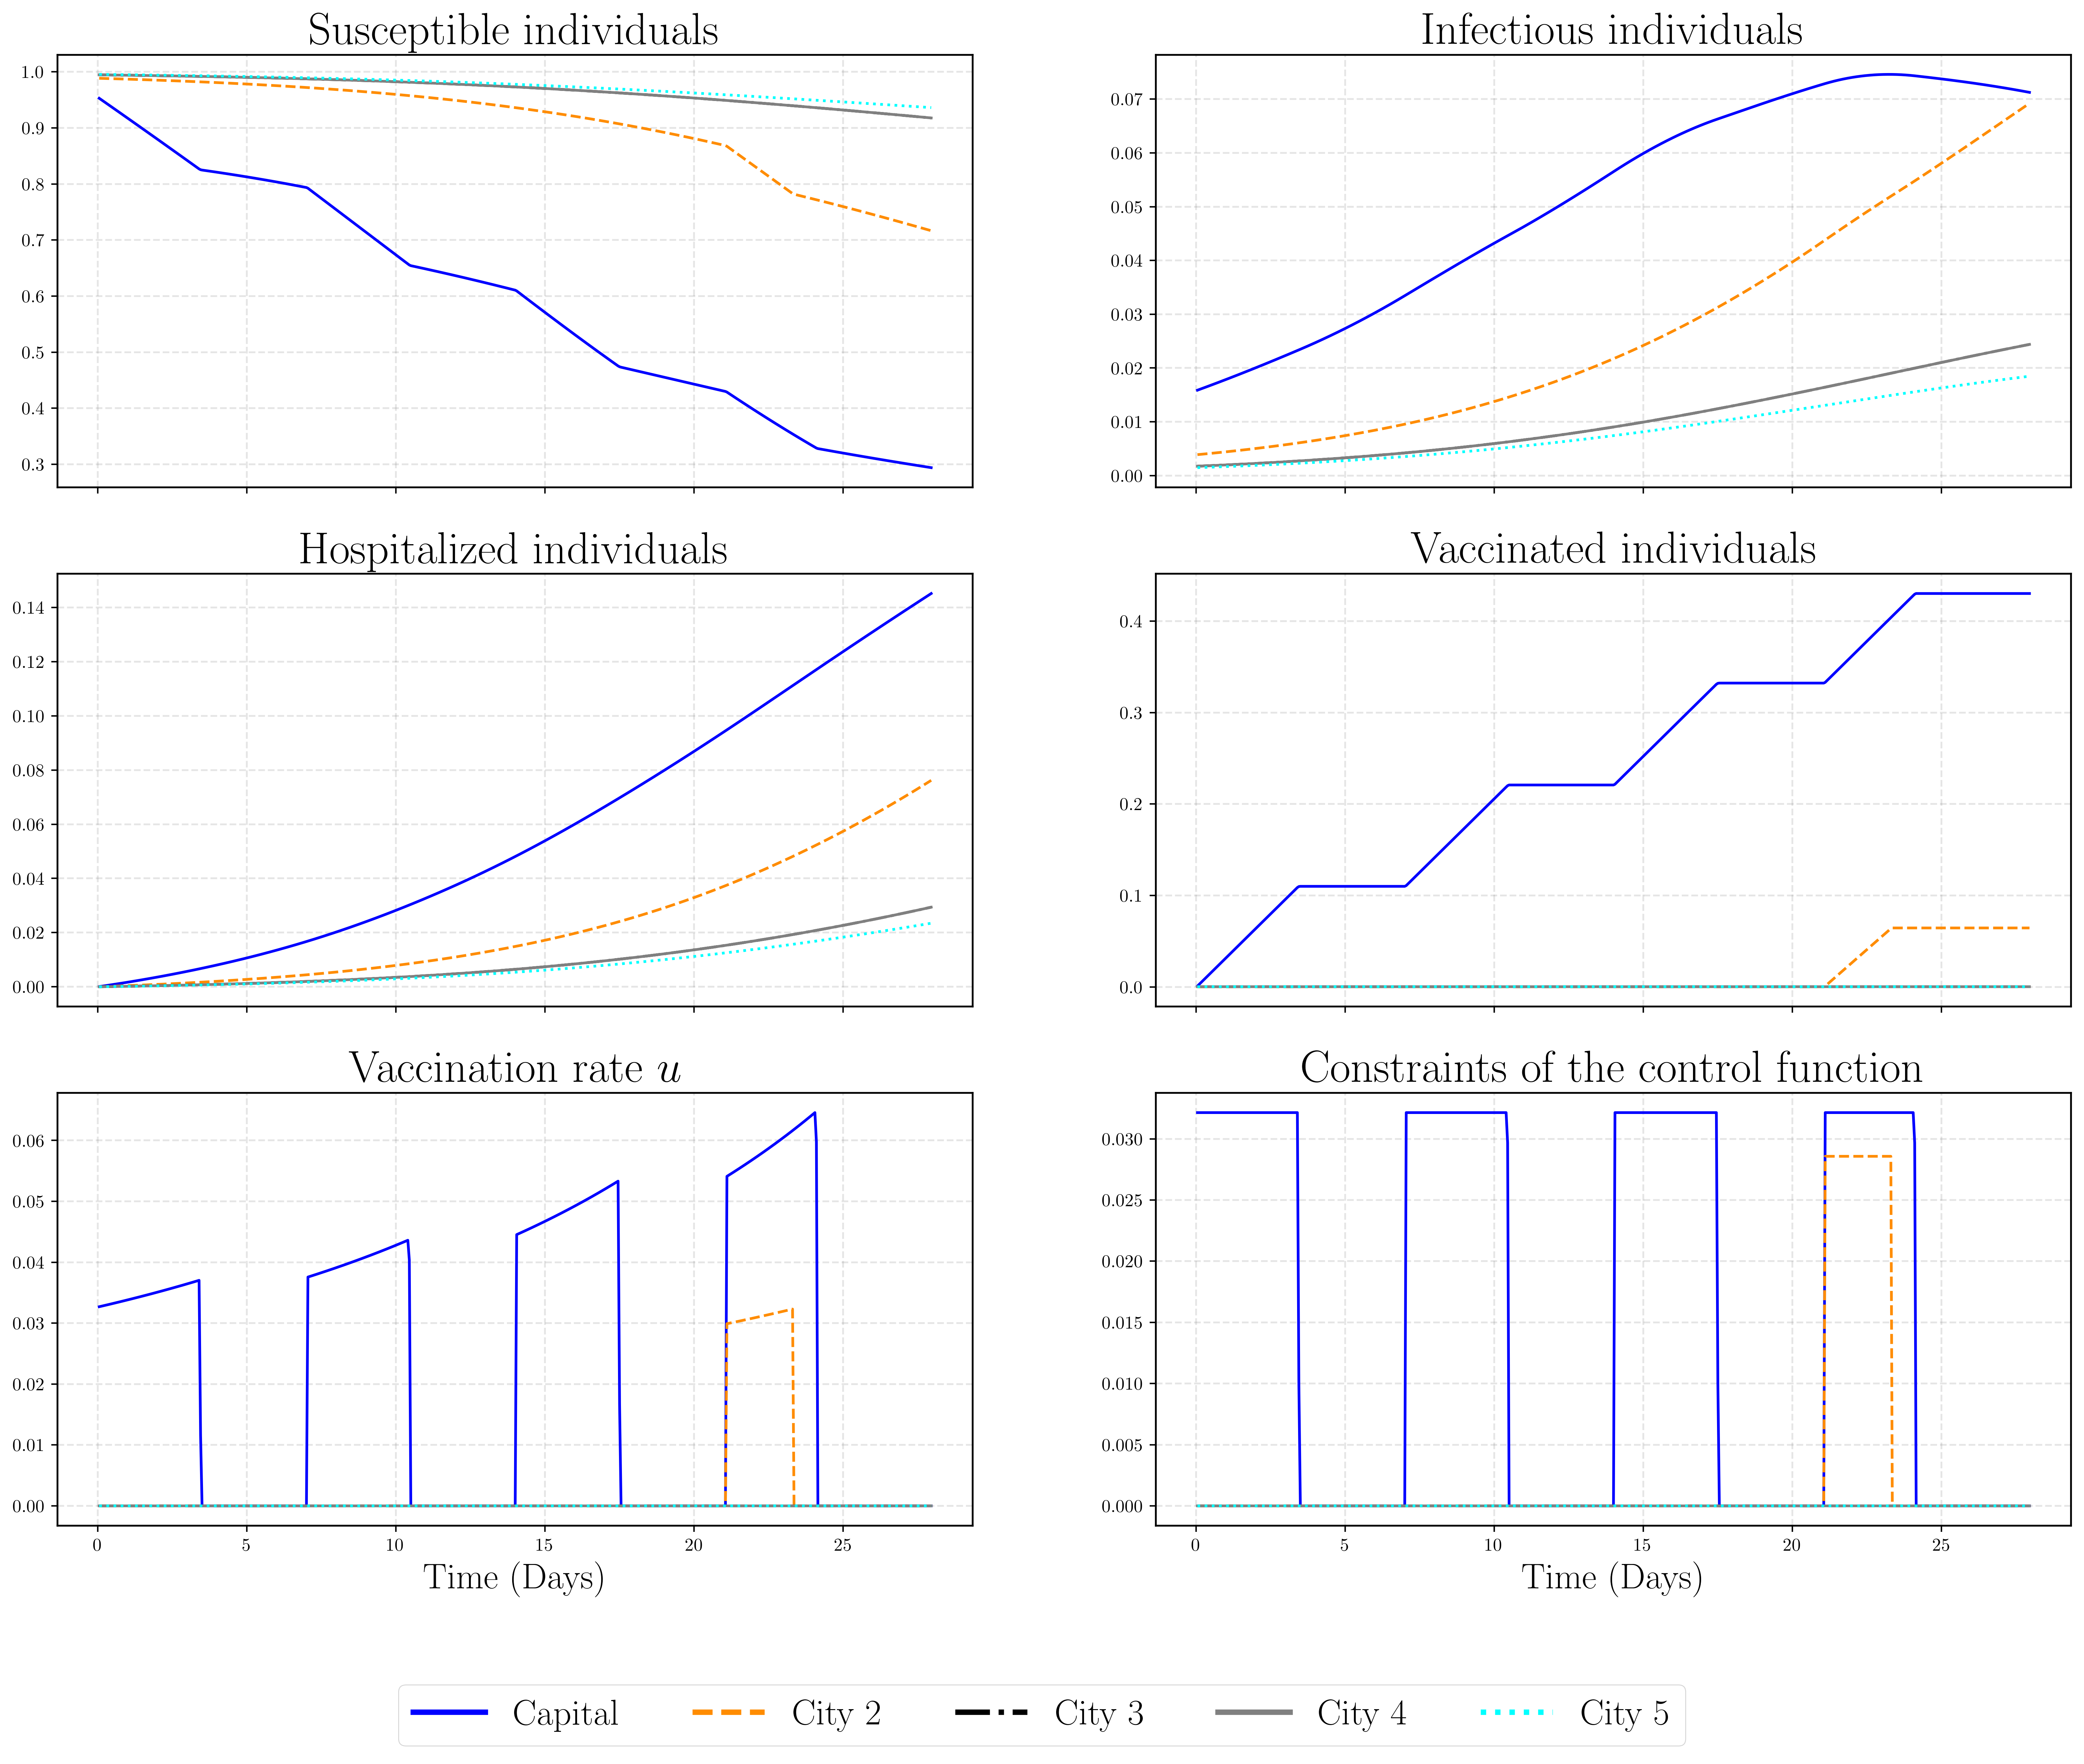

In [26]:
fig, ax = plt.subplots(3,2, figsize=(20,15), sharex=True)

colors = ['blue', 'darkorange', 'black', 'gray', 'cyan']
linestyles = ['-', '--', '-.', '-', ':']
labels = ['Capital', 'City 2', 'City 3', 'City 4', 'City 5']

for city in range(len(populations)):
    
    ax[0,0].plot(m.time[1:-1], susceptible[city][1:-1], c=colors[city], ls=linestyles[city])
    ax[0,1].plot(m.time[1:-1], infected[city][1:-1], c=colors[city], ls=linestyles[city])
    
    ax[1,0].plot(m.time[1:-1], hospitalized[city][1:-1], c=colors[city], ls=linestyles[city])
    ax[1,1].plot(m.time[1:-1], vaccinated[city][1:-1], c=colors[city], ls=linestyles[city])
    
    ax[2,0].plot(m.time[1:-1], u[city][1:-1], c=colors[city], ls=linestyles[city])
    
    constraint = np.array(u[city])*(np.array(susceptible[city])+np.array(exposed[city])+np.array(recovered[city]))
    
    ax[2,1].plot(m.time[1:-1], constraint[1:-1], color=colors[city], ls=linestyles[city])
    
for i in range(3):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
ax[0,0].set_title('Susceptible individuals', fontsize=25)
ax[0,1].set_title('Infectious individuals', fontsize=25)
ax[1,0].set_title('Hospitalized individuals', fontsize=25)
ax[1,1].set_title('Vaccinated individuals', fontsize=25)
ax[2,0].set_title(r'Vaccination rate $u$', fontsize=25)
ax[2,1].set_title('Constraints of the control function', fontsize=25)

ax[2,0].set_xlabel('Time (Days)', fontsize=20)
ax[2,1].set_xlabel('Time (Days)', fontsize=20)

# Create a legend for the whole figure
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle=ls) for c, ls in zip(colors, linestyles)]
fig.legend(lines, labels, loc='lower center', fontsize=20, ncol=5)

plt.savefig('../images/numerical_simulations_control_fig4.pdf', bbox_inches='tight')

plt.show()

Different parameters

In [7]:
# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
beta = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
alpha = 0.64

# Population settings
x1 = 0.3
populations = 1e5*np.array([10, 10, 10, 10, 10])
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = populations @ p_matrix

# Initial condition
y0 = np.zeros(5*K)
y0[K] = 1/populations[0]
y0[0:K] = 1-y0[K:2*K]

T = 28

rate_max = np.array([0.8, 0.8, 0.8, 0.8, 0.8])/T
week_max = np.array([1, 2, 3, 4, 5, 6, 7, 8])/13

args = (np.zeros(5), alpha, beta, tau, gamma, K, p_matrix, populations, population_eff)

n_days = 180
t_eval = np.linspace(0, n_days, 100 * n_days)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
                max_step=1e-2
               )

parameters = {'T': T, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': sol.y[K:2*K,90*100], 
              'i0': sol.y[2*K:3*K,90*100], 
              'r0': sol.y[3*K:4*K,90*100],
              'cv': 0.01, 'ch': 1000, 'rh': 0.1,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-6, 'OTOL': 1e-6}

In [8]:
m2, susceptible2, exposed2, infected2, recovered2, vaccinated2, hospitalized2, u2 = optimal_vaccination_strategy(parameters)

apm 189.125.124.24_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           49
   Intermediates:            5
   Connections  :            0
   Equations    :           45
   Residuals    :           40
 
 Number of state variables:         218400
 Number of total equations: -       215600
 Number of slack variables: -        25200
 ---------------------------------------
 Degrees of freedom       :         -22400
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This

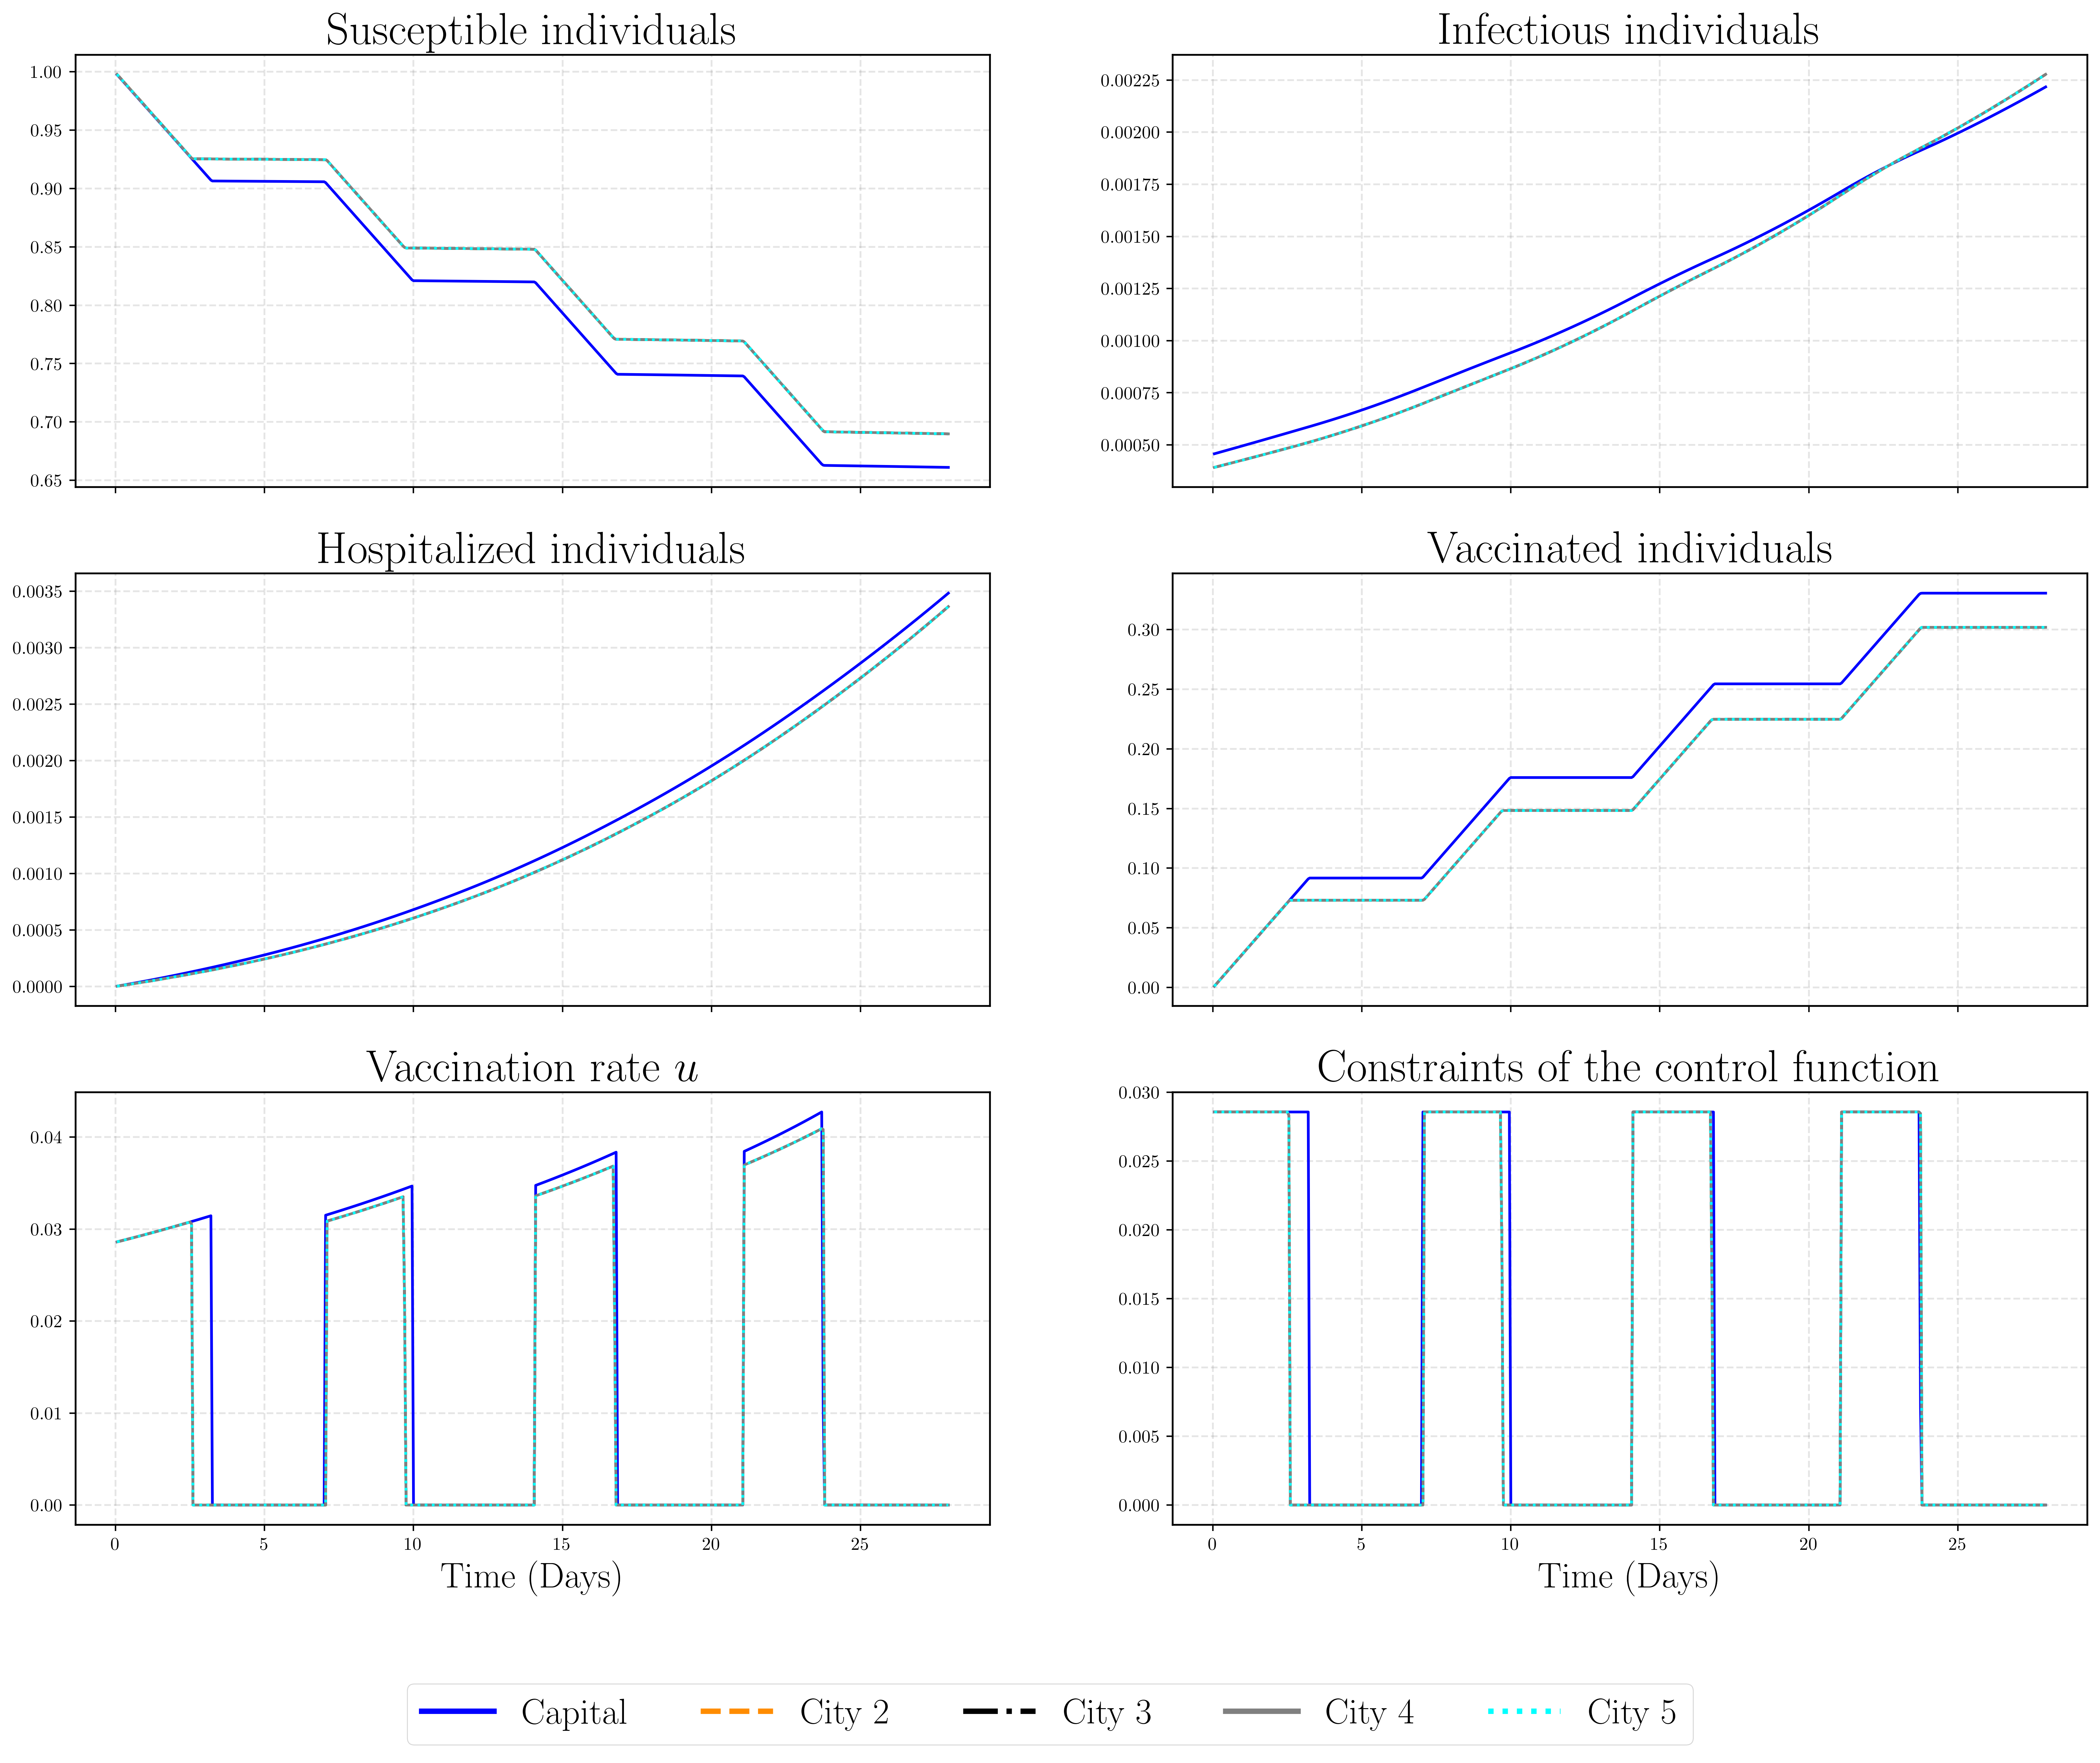

In [29]:
fig, ax = plt.subplots(3,2, figsize=(20,15), sharex=True)

colors = ['blue', 'darkorange', 'black', 'gray', 'cyan']
linestyles = ['-', '--', '-.', '-', ':']
labels = ['Capital', 'City 2', 'City 3', 'City 4', 'City 5']

for city in range(len(populations)):
    
    ax[0,0].plot(m2.time[1:-1], susceptible2[city][1:-1], c=colors[city], ls=linestyles[city])
    ax[0,1].plot(m2.time[1:-1], infected2[city][1:-1], c=colors[city], ls=linestyles[city])
    
    ax[1,0].plot(m2.time[1:-1], hospitalized2[city][1:-1], c=colors[city], ls=linestyles[city])
    ax[1,1].plot(m2.time[1:-1], vaccinated2[city][1:-1], c=colors[city], ls=linestyles[city])
    
    ax[2,0].plot(m2.time[1:-1], u2[city][1:-1], c=colors[city], ls=linestyles[city])
    
    constraint = np.array(u2[city])*(np.array(susceptible2[city])+np.array(exposed2[city])+np.array(recovered2[city]))
    
    ax[2,1].plot(m2.time[1:-1], constraint[1:-1], color=colors[city], ls=linestyles[city])
    
for i in range(3):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
ax[0,0].set_title('Susceptible individuals', fontsize=25)
ax[0,1].set_title('Infectious individuals', fontsize=25)
ax[1,0].set_title('Hospitalized individuals', fontsize=25)
ax[1,1].set_title('Vaccinated individuals', fontsize=25)
ax[2,0].set_title(r'Vaccination rate $u$', fontsize=25)
ax[2,1].set_title('Constraints of the control function', fontsize=25)

ax[2,0].set_xlabel('Time (Days)', fontsize=20)
ax[2,1].set_xlabel('Time (Days)', fontsize=20)

# Create a legend for the whole figure
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle=ls) for c, ls in zip(colors, linestyles)]
fig.legend(lines, labels, loc='lower center', fontsize=20, ncol=5)

plt.savefig('../images/numerical_simulations_control_fig5.pdf', bbox_inches='tight')

plt.show()

In [37]:
def optimal_vaccination_strategy_feedback(parameters):
    
    # Gekko object
    m = gk.GEKKO()
    
    # Including the time
    T = parameters['T']
    npd = 20
    n_points = npd*T + 1
    m.time = np.linspace(0, T, n_points)

    # Number of cities
    populations = parameters['populations']/parameters['populations'].sum()
    K = len(populations)

    # Parameters
    beta = parameters['beta']
    cv = m.Const(parameters['cv'])
    ch = m.Const(parameters['ch'])
    rh = m.Const(parameters['rh'])
    alpha = m.Const(parameters['alpha'])
    tau = m.Const(parameters['tau'])
    gamma = m.Const(parameters['gamma'])
    p = parameters['p_matrix']
    population_eff = populations @ p_matrix

    # Initial values
    e0 = parameters['e0']
    i0 = parameters['i0']
    r0 = parameters['r0']
    s0 = np.ones(K) - e0 - i0 - r0
    
    # Constraints
    week_max = parameters['week_max']
    rate_max = parameters['rate_max']

    # Including the variables
    s = m.Array(m.Var, K, lb=0.0)
    e = m.Array(m.Var, K, lb=0.0)
    i = m.Array(m.Var, K, lb=0.0)
    r = m.Array(m.Var, K, lb=0.0)
    v = m.Array(m.Var, K, lb=0.0, value=0.0)
    h = m.Array(m.Var, K, lb=0.0, value=0.0)

    u = [m.MV(lb=0.0, value=0.01, name='u{}'.format(city)) for city in range(K)]
    for city in range(K):
        s[city].value = s0[city]
        e[city].value = e0[city]
        i[city].value = i0[city]
        r[city].value = r0[city]
        
        u[city].STATUS = 1
        u[city].DCOST = 0

    # Maximizing 
    obj_points = np.zeros(n_points)
    obj_points[-1] = 1.0
    final = m.Param(value=obj_points)
    m.Obj(cv * m.sum(v*populations) * final + ch * m.sum(h*populations) * final)

    # ODE equations
    i_eff = [m.Intermediate(m.sum(p_matrix[:,city]*populations*i)/population_eff[city]) for city in range(K)]
    for city in range(K):
        new_infections = s[city] * (alpha*beta[city]*i[city] + (1-alpha)*m.sum(beta*p_matrix[city,:]*i_eff))
        m.Equation(s[city].dt() == -new_infections - s[city]*u[city])
        m.Equation(e[city].dt() == new_infections - (tau+u[city])*e[city])
        m.Equation(i[city].dt() == tau*e[city] - gamma*i[city])
        m.Equation(r[city].dt() == gamma*i[city] - u[city]*r[city])
        m.Equation(v[city].dt() == u[city]*(s[city] + e[city] + r[city]))
        m.Equation(h[city].dt() == rh*i[city])
        
        # The vaccination rate is limited
        m.Equation(u[city]*(1 - v[city]) <= rate_max[city])
        
        
    weekly_constraint = []
    weekly_mark = []
    for week in range(T//7):
        weekly_mark.append(np.zeros(n_points))
        weekly_mark[-1][npd*7*(week+1)] = 1.0
        weekly_constraint.append(m.Param(value=weekly_mark[-1]))
        m.Equation( m.sum(v * populations) * weekly_constraint[-1] <= week_max[week])

    # Solving
    m.options.IMODE = 6
    m.options.NODES = 6
    m.options.MV_TYPE = 1
    m.options.SOLVER = 3  # Using IPOPT solver
    m.options.MAX_ITER = 500
    
    m.options.RTOL=parameters['RTOL']
    m.options.OTOL=parameters['OTOL']

    m.solve(disp=True)
    
    return m, s, e, i, r, v, h, u

In [38]:
# number of cities
K = 5

# Fixed parameters
tau = 1/3
gamma = 1/7
mu = 3e-5
beta = np.array([0.4, 0.3, 0.15, 0.15, 0.1])
alpha = 0.64

# Population settings
x1 = 0.2
populations = 1e5*np.array([50, 10, 10, 1, 1])
p_matrix = np.array([[1,0,0,0,0],[x1,1-x1,0,0,0],[x1,0,1-x1,0,0],[x1,0,0,1-x1,0],[x1,0,0,0,1-x1]])
population_eff = populations @ p_matrix

# Initial condition
y0 = np.zeros(5*K)
y0[K] = 1/populations[0]
y0[0:K] = 1-y0[K:2*K]

T = 28

rate_max = np.array([0.9, 0.8, 0.8, 0.8, 0.8])/T
week_max = np.array([1, 2, 3, 4, 5, 6, 7, 8])/13

args = (np.zeros(5), alpha, beta, tau, gamma, K, p_matrix, populations, population_eff)

n_days = 180
t_eval = np.linspace(0, n_days, 100 * n_days)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
                max_step=1e-2
               )

In [39]:
%%time
parameters = {'T': T, 'populations': populations, 'p_matrix': p_matrix,
              'beta': beta, 'alpha': alpha, 'tau': tau, 'gamma': gamma, 
              'e0': sol.y[K:2*K,90*100], 
              'i0': sol.y[2*K:3*K,90*100], 
              'r0': sol.y[3*K:4*K,90*100],
              'cv': 0.01, 'ch': 1000, 'rh': 0.1,
              'week_max': week_max,
              'rate_max': rate_max,
              'RTOL': 1e-6, 'OTOL': 1e-6}

m3, susceptible3, exposed3, infected3, recovered3, vaccinated3, hospitalized3, u3 = optimal_vaccination_strategy_feedback(parameters)

apm 189.125.124.24_gk_model3 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            6
   Variables    :           49
   Intermediates:            5
   Connections  :            0
   Equations    :           45
   Residuals    :           40
 
 Number of state variables:         218400
 Number of total equations: -       215600
 Number of slack variables: -        25200
 ---------------------------------------
 Degrees of freedom       :         -22400
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This

CPU times: total: 78.1 ms
Wall time: 1h 22min 21s


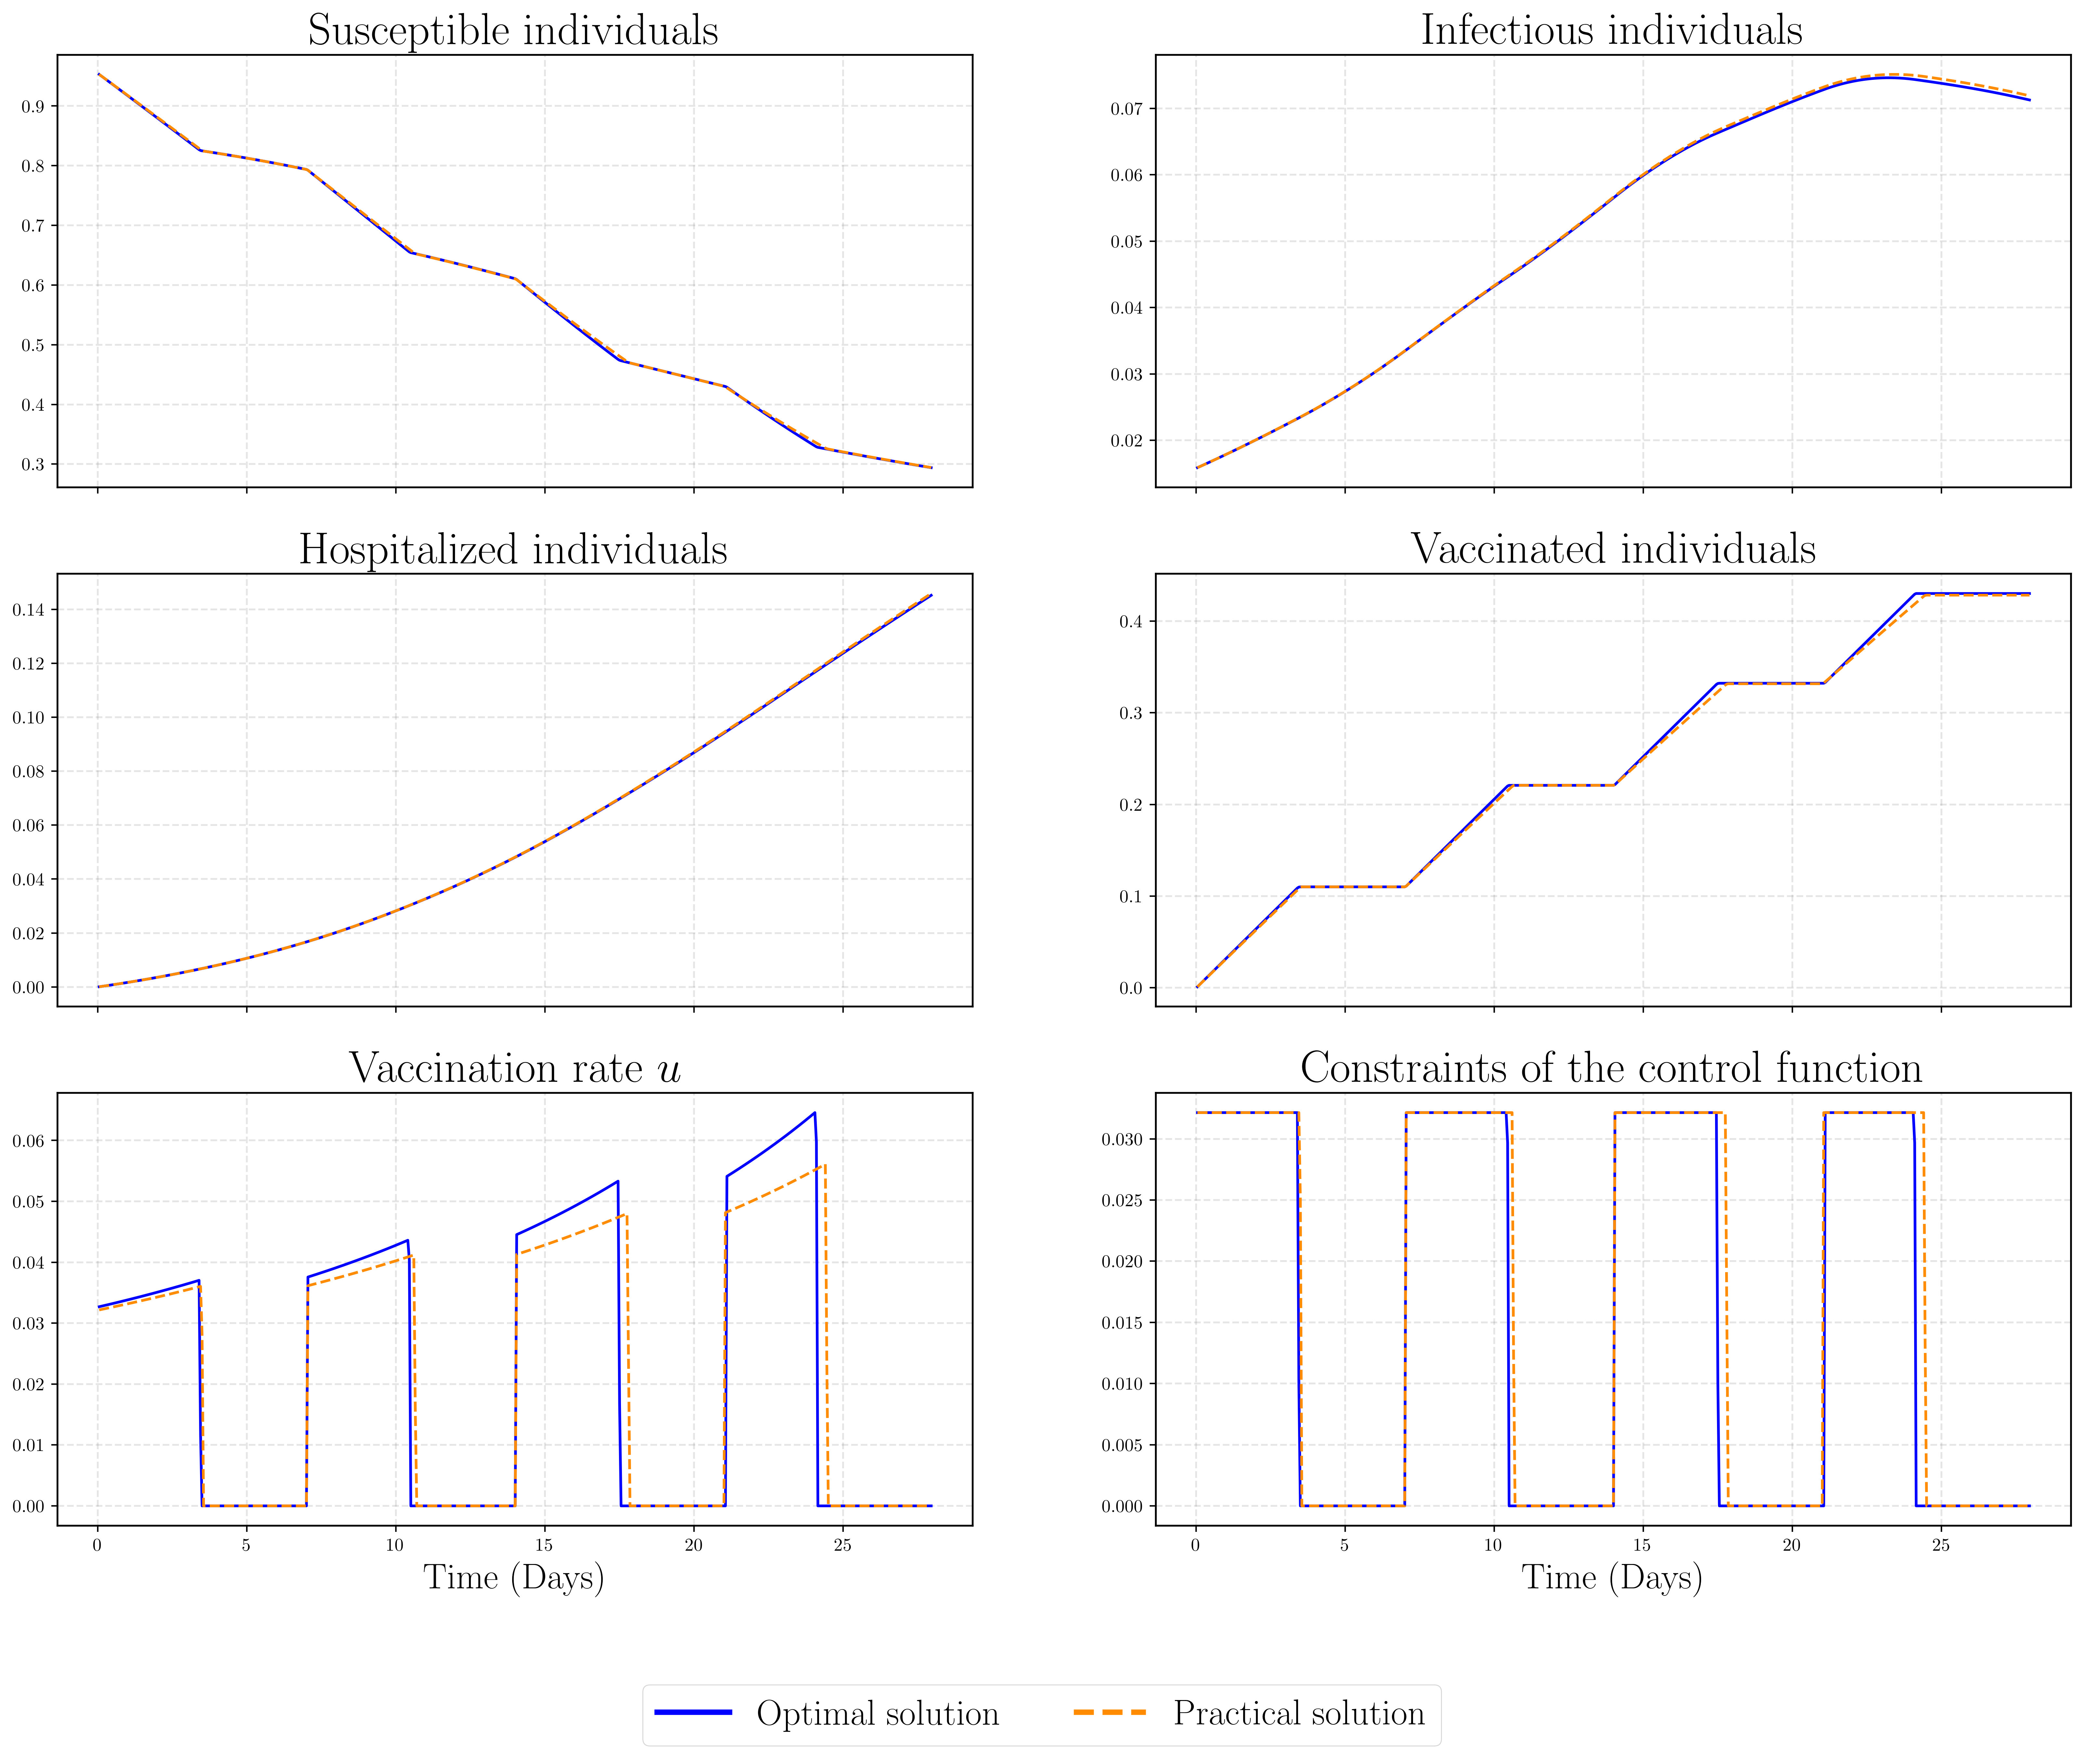

In [47]:
fig, ax = plt.subplots(3,2, figsize=(20,15), sharex=True)

colors = ['blue', 'darkorange']
linestyles = ['-', '--']
labels = ['Optimal solution', 'Practical solution']

ax[0,0].plot(m.time[1:-1], susceptible[0][1:-1], c=colors[0], ls=linestyles[0])
ax[0,1].plot(m.time[1:-1], infected[0][1:-1], c=colors[0], ls=linestyles[0])

ax[1,0].plot(m.time[1:-1], hospitalized[0][1:-1], c=colors[0], ls=linestyles[0])
ax[1,1].plot(m.time[1:-1], vaccinated[0][1:-1], c=colors[0], ls=linestyles[0])

ax[2,0].plot(m.time[1:-1], u[0][1:-1], c=colors[0], ls=linestyles[0])

constraint = np.array(u[0])*(np.array(susceptible[0]) + np.array(exposed[0]) + np.array(recovered[0]))

ax[2,1].plot(m.time[1:-1], constraint[1:-1], color=colors[0], ls=linestyles[0])

ax[0,0].plot(m3.time[1:-1], susceptible3[0][1:-1], c=colors[1], ls=linestyles[1])
ax[0,1].plot(m3.time[1:-1], infected3[0][1:-1], c=colors[1], ls=linestyles[1])

ax[1,0].plot(m3.time[1:-1], hospitalized3[0][1:-1], c=colors[1], ls=linestyles[1])
ax[1,1].plot(m3.time[1:-1], vaccinated3[0][1:-1], c=colors[1], ls=linestyles[1])

ax[2,0].plot(m3.time[1:-1], u3[0][1:-1], c=colors[1], ls=linestyles[1])

constraint = np.array(u3[0])*(1 - np.array(vaccinated3[0]))

ax[2,1].plot(m3.time[1:-1], constraint[1:-1], color=colors[1], ls=linestyles[1])
    
for i in range(3):
    for j in range(2):
        ax[i,j].grid(color='grey', linestyle='--', linewidth=1, alpha=0.2, zorder=1)
    
    
ax[0,0].set_title('Susceptible individuals', fontsize=25)
ax[0,1].set_title('Infectious individuals', fontsize=25)
ax[1,0].set_title('Hospitalized individuals', fontsize=25)
ax[1,1].set_title('Vaccinated individuals', fontsize=25)
ax[2,0].set_title(r'Vaccination rate $u$', fontsize=25)
ax[2,1].set_title('Constraints of the control function', fontsize=25)

ax[2,0].set_xlabel('Time (Days)', fontsize=20)
ax[2,1].set_xlabel('Time (Days)', fontsize=20)

# Create a legend for the whole figure
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle=ls) for c, ls in zip(colors, linestyles)]
fig.legend(lines, labels, loc='lower center', fontsize=20, ncol=5)

plt.savefig('../images/numerical_simulations_control_fig6.pdf', bbox_inches='tight')

plt.show()